In [1]:
!pip install diffusers -q

In [2]:
import torch
import torchvision
import random
from diffusers import DDPMScheduler, UNet2DModel, UNet2DConditionModel
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm
import sys
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
sys.path.append('/kaggle/input/gan-lib')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Using device: cuda


In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)  # Фиксируем seed для встроенного генератора Python
    np.random.seed(seed)  # Фиксируем seed для NumPy
    torch.manual_seed(seed)  # Фиксируем seed для PyTorch (CPU)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # Фиксируем seed для PyTorch (CUDA)
        torch.cuda.manual_seed_all(seed)  # Фиксируем seed для всех доступных GPU
        torch.backends.cudnn.deterministic = True  # Гарантируем детерминированность CUDNN
        torch.backends.cudnn.benchmark = False  # Отключаем эвристику для оптимизации скорости

# Вызов функции для установки seed
set_seed(0x3df3fa)

In [4]:
# Параметры
url = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
public_key = "https://disk.yandex.ru/d/hcnBVM-FbKdwEQ"
output_path = "data_demo/caloGAN_case11_5D_120K.npz"

# Создание папки
os.makedirs("data_demo", exist_ok=True)

# Получение ссылки для скачивания
response = requests.get(url, params={"public_key": public_key})
download_url = response.json().get("href")

# Скачивание файла
with requests.get(download_url, stream=True) as r:
    r.raise_for_status()
    with open(output_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

print(f"Файл сохранен в {output_path}")

Файл сохранен в data_demo/caloGAN_case11_5D_120K.npz


In [5]:
# Загрузка файла
file_path = "data_demo/caloGAN_case11_5D_120K.npz"
data = np.load(file_path)

# Вывод ключей
print("Ключи в файле:", data.keys())
for key in data.keys():
    print(f"{key}: {data[key].shape, data[key][0].shape, type(data[key][0])}")

Ключи в файле: KeysView(NpzFile 'data_demo/caloGAN_case11_5D_120K.npz' with keys: EnergyDeposit, TotalEnergySci, TotalEnergyAbsorb, ParticlePoint, ParticleMomentum...)
EnergyDeposit: ((120000, 30, 30, 1), (30, 30, 1), <class 'numpy.ndarray'>)
TotalEnergySci: ((120000,), (), <class 'numpy.float64'>)
TotalEnergyAbsorb: ((120000,), (), <class 'numpy.float64'>)
ParticlePoint: ((120000, 3), (3,), <class 'numpy.ndarray'>)
ParticleMomentum: ((120000, 3), (3,), <class 'numpy.ndarray'>)
ParticlePDG: ((120000,), (), <class 'numpy.int32'>)


In [6]:
# Анализ каждого массива
for key in data.keys():
    array = data[key]
    print(f"\nАнализ для ключа '{key}':")
    
    if array.ndim == 1:  # Одномерный массив (как колонка таблицы)
        df = pd.DataFrame(array, columns=[key])
    elif array.ndim == 2:  # Двумерный массив (как таблица)
        df = pd.DataFrame(array)
    else:
        print(f"Пропущен ключ '{key}' (размерность {array.ndim}, {array.shape})")
        continue  # Пропустить многомерные данные

    # Вывод статистики
    print(df.describe())
    if key == 'ParticlePDG':
        print(set(list(df['ParticlePDG'])))


Анализ для ключа 'EnergyDeposit':
Пропущен ключ 'EnergyDeposit' (размерность 4, (120000, 30, 30, 1))

Анализ для ключа 'TotalEnergySci':
       TotalEnergySci
count   120000.000000
mean      3689.362197
std       4288.969798
min         17.744208
25%        542.614813
50%       1709.540527
75%       5419.721051
max      17534.086880

Анализ для ключа 'TotalEnergyAbsorb':
       TotalEnergyAbsorb
count      120000.000000
mean        17397.111282
std         20215.919290
min            25.657121
25%          2567.082372
50%          8054.721240
75%         25567.709499
max         81849.061099

Анализ для ключа 'ParticlePoint':
                   0              1             2
count  120000.000000  120000.000000  1.200000e+05
mean        0.017271       0.001772 -1.980000e+01
std         2.685174       2.688257  7.151642e-12
min       -13.112130     -13.057561 -1.980000e+01
25%        -1.791773      -1.819817 -1.980000e+01
50%         0.011696      -0.005348 -1.980000e+01
75%         1.8

In [7]:
class PhysicsDataset(torch.utils.data.Dataset):
    """
    one element: (energy deposit, (point, momentum))
    """
    def __init__(self, energy: torch.Tensor, condition: torch.Tensor,
                 transform=None, inverse_transform=None) -> None:
        self.transform = transform
        self.inverse_transform = inverse_transform  # for outer use

        if transform is not None:
            energy = self.transform(energy)

        self.energy = energy
        self.physic_condition = condition

    def __getitem__(self, idx: int) -> tuple:
        return self.energy[idx], self.physic_condition[idx]

    def __len__(self) -> int:
        return self.energy.shape[0]

# принимают batch-и x-ов
def log1p_transform(x: torch.Tensor):
    return torch.log1p(x)


def log1p_inverse_transform(x: torch.Tensor):
    return torch.expm1(x)

def get_physics_dataset(path: str, train: bool = True, val_ratio: float = 0.5,
                        log1p_energy: bool = True) -> torch.utils.data.Dataset:

    """
    Получение данных из файла .npz и формирование датасета для обучения. 
    Данные получаются из файла все, но на обучение идет только импульс и координаты
    """
    TRAIN_VAL_SPLIT_SEED = 0x3df3fa

    data_train = np.load(path)

    np.random.seed(TRAIN_VAL_SPLIT_SEED)
    dataset_size = len(data_train['EnergyDeposit'])
    val_size = int(dataset_size * val_ratio)

    all_indices = np.arange(dataset_size)
    val_indices = np.random.choice(all_indices, size=val_size, replace=False)
    val_mask = np.zeros(dataset_size, dtype=bool)
    val_mask[val_indices] = True
    train_indices = all_indices[~val_mask]
    indices = train_indices if train else val_indices

    energy = torch.tensor(data_train['EnergyDeposit'][indices]).float()
    energy = torch.permute(energy, dims=(0, 3, 1, 2))
    
    momentum = torch.tensor(data_train['ParticleMomentum'][indices]).float()
    momentum_norm = momentum / torch.norm(momentum, dim=1, keepdim=True) # нормировка
    pt = np.sqrt(momentum[:, 0]**2 + momentum[:, 1]**2)
    eta = - np.log(pt/momentum[:, 2])
    phi = np.arctan2(momentum[:, 0], momentum[:, 1])
    momentum_cyl = torch.stack([pt, eta, phi], dim=1) 
    
    total_energy_sci = torch.tensor(data_train['TotalEnergySci'][indices]).float()
    total_energy_sci_min_val = total_energy_sci.min()
    total_energy_sci_max_val = total_energy_sci.max()
    total_energy_sci_norm = (total_energy_sci/total_energy_sci_max_val).unsqueeze(1)  # [0, 1]

    total_energy_absorb = torch.tensor(data_train['TotalEnergyAbsorb'][indices]).float()
    total_energy_absorb_min_val = total_energy_absorb.min()
    total_energy_absorb_max_val = total_energy_absorb.max()
    total_energy_absorb_norm = (total_energy_absorb/total_energy_absorb_max_val).unsqueeze(1)  # [0, 1]

    point = torch.tensor(data_train['ParticlePoint'][indices]).float()
    point_norm = point / torch.norm(point, dim=1, keepdim=True) # нормировка

    
    
    physic_condition = torch.cat([momentum_norm,
                                  momentum_cyl,
                                    point_norm
                                    ], dim=1)  # (N, 8)
    transform, inverse_transform = None, None
    if log1p_energy:
        transform = log1p_transform
        inverse_transform = log1p_inverse_transform

    return PhysicsDataset(energy,
                          physic_condition,
                          transform=transform, inverse_transform=inverse_transform)

In [8]:
data_filepath = "/kaggle/working/data_demo/caloGAN_case11_5D_120K.npz"
train_dataset = get_physics_dataset(data_filepath, train=True)
valid_dataset = get_physics_dataset(data_filepath, train=False)

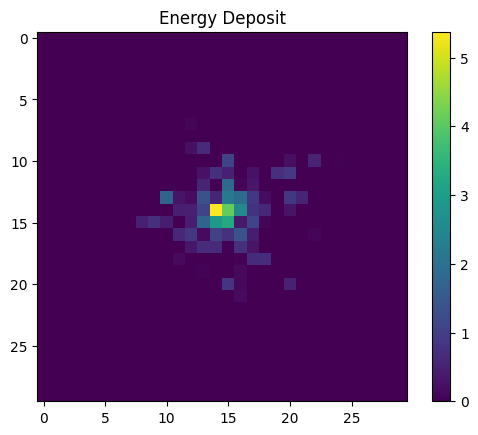

Physic conditions: tensor([ 0.0522,  0.0852,  0.9950,  0.2386,  2.2984,  0.5502, -0.0696, -0.0608,
        -0.9957])


In [9]:
# Первый элемент тренировочного набора
energy, physic_condition = train_dataset[0]
energy_image = energy[0].numpy()  # Если 1 канал, берём первый
plt.imshow(energy_image, cmap='viridis')  # Можно выбрать подходящую цветовую карту
plt.colorbar()
plt.title("Energy Deposit")
plt.show()
print(f"Physic conditions: {physic_condition}")

In [10]:
for batch in train_dataset:
    print(batch[0].size())
    break  # Достаточно одного батча для просмотра

torch.Size([1, 30, 30])


In [11]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
batch_size = 8
num_batches = 10
num_samples = batch_size * num_batches  # 1000 примеров

valid_subset = Subset(valid_dataset, indices=range(min(num_samples, len(valid_dataset))))

valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=True)

In [12]:
import sys
del sys.path[-1]
sys.path.append('/kaggle/input/gan-lib')

from pipeline.metrics import *
from pipeline.physical_metrics.calogan_prd import get_energy_embedding, calc_pr_rec_from_embeds, plot_pr_aucs
from pipeline.physical_metrics import calogan_metrics
from pipeline.physical_metrics.prd_score import compute_prd_from_embedding, prd_to_max_f_beta_pair

/kaggle/input/gan-lib/pipeline/physical_metrics/calogan_prd.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_path)


In [13]:
def get_assymetry(imgs, ps, points, orthog=False):
    assym_res = []
    zoff = 25
    
    x = np.linspace(-14.5, 14.5, 30)
    y = np.linspace(-14.5, 14.5, 30)
    xx, yy = np.meshgrid(x, y)
    xx = np.repeat(xx[np.newaxis, ...], len(imgs), axis=0)
    yy = np.repeat(yy[np.newaxis, ...], len(imgs), axis=0)
    
    # Добавляем защиту от деления на ноль
    ps_safe = ps.copy()
    ps_safe[:, 2] = np.where(ps[:, 2] == 0, 1e-10, ps[:, 2])  # Защита для z-компоненты
    points_0 = points[:, 0] + zoff * ps_safe[:, 0] / ps_safe[:, 2]
    points_1 = points[:, 1] + zoff * ps_safe[:, 1] / ps_safe[:, 2]
    
    # Защита для горизонтальных/вертикальных линий
    ps_safe[:, 0] = np.where(ps[:, 0] == 0, 1e-10, ps[:, 0])
    ps_safe[:, 1] = np.where(ps[:, 1] == 0, 1e-10, ps[:, 1])
    
    if orthog:
        line_func = lambda x: (x - points_0[..., np.newaxis, np.newaxis]) / (ps_safe[:, 0] / ps_safe[:, 1])[..., np.newaxis, np.newaxis] + points_1[..., np.newaxis, np.newaxis]
    else:
        line_func = lambda x: -(x - points_0[..., np.newaxis, np.newaxis]) / (ps_safe[:, 1] / ps_safe[:, 0])[..., np.newaxis, np.newaxis] + points_1[..., np.newaxis, np.newaxis]

    sign = np.ones(len(ps_safe))
    if not orthog:
        sign = (ps_safe[:, 1] > 0).astype(int)
        sign = 2 * (sign - 0.5)
    
    idx = np.where((yy - line_func(xx)) * sign[..., np.newaxis, np.newaxis] < 0)        
    zz = np.ones((len(imgs), 30, 30))
    zz[idx] = 0
    
    # Защита от деления на ноль
    total_energy = np.sum(imgs, axis=(1, 2))
    safe_denominator = np.where(total_energy == 0, 1e-10, total_energy)  # Заменяем нули
    
    numerator = np.sum(imgs * zz, axis=(1, 2))
    assym = (numerator - (total_energy - numerator)) / safe_denominator
    
    return np.nan_to_num(assym, nan=0.0, posinf=0.0, neginf=0.0)

In [14]:
def filter_invalid_rows(arr1, arr2):
    """Фильтрует строки с NaN, Inf или малыми значениями Asymmetry."""
    valid_indices = [
        i for i in range(len(arr1)) 
        if not (np.isnan(arr1[i]).any() or np.isinf(arr1[i]).any() or
                np.isnan(arr2[i]).any() or np.isinf(arr2[i]).any() or
                (abs(arr1[i, 0]) < 20 or abs(arr2[i, 0]) < 20) or  # Проверяем Longitudinal Asymmetry
                (abs(arr1[i, 1]) < 50 or abs(arr2[i, 1]) < 50)      # Проверяем Transverse Asymmetry
        )
    ]
    return arr1[valid_indices], arr2[valid_indices]


In [15]:
class DiffusionPhysicsMetrics:
    """Считает 5 физических метрик для изображений, полученных из диффузионной модели"""

    def __init__(self,
                 num_clusters: int = 20,
                 num_runs: int = 10,
                 enforce_balance: bool = True,
                 statistics: list = ['Longitudual Asymmetry',
                                     'Transverse Asymmetry',
                                     'Longitudual Width',
                                     'Transverse Width', 
                                     'PRD AUC']):
        self.num_clusters = num_clusters
        self.num_runs = num_runs
        self.enforce_balance = enforce_balance
        self.statistics = statistics

    def evaluate(self, gen_images, real_images, conditions):
        """Переводит данные в numpy и считает метрики"""
        gen_images_np = gen_images.cpu().numpy()
        real_images_np = real_images.cpu().numpy()
        
        # 4 Метрики асимметрии и ширины
        physics_metrics = {
            "Gen Longitudual Asymmetry": get_assymetry(gen_images_np,
                                                                       conditions[:, 0:3],
                                                                       conditions[:, 6:],
                                                                       orthog=False).flatten(),
            "Gen Transverse Asymmetry": get_assymetry(gen_images_np,
                                                                      conditions[:, 0:3],
                                                                      conditions[:, 6:],
                                                                      orthog=True).flatten(),
            "Gen Longitudual Width": calogan_metrics.get_shower_width(gen_images_np,
                                                                      conditions[:, 0:3],
                                                                      conditions[:, 6:],
                                                                      orthog=False).flatten(),
            "Gen Transverse Width": calogan_metrics.get_shower_width(gen_images_np,
                                                                     conditions[:, 0:3],
                                                                     conditions[:, 6:], orthog=True).flatten(),

            "Real Longitudual Asymmetry": get_assymetry(real_images_np,
                                                                        conditions[:, 0:3],
                                                                        conditions[:, 6:],
                                                                        orthog=False).flatten(),
            "Real Transverse Asymmetry": get_assymetry(real_images_np,
                                                                       conditions[:, 0:3],
                                                                       conditions[:, 6:],
                                                                       orthog=True).flatten(),
            "Real Longitudual Width": calogan_metrics.get_shower_width(real_images_np,
                                                                       conditions[:, 0:3],
                                                                       conditions[:, 6:],
                                                                       orthog=False).flatten(),
            "Real Transverse Width": calogan_metrics.get_shower_width(real_images_np,
                                                                      conditions[:, 0:3],
                                                                      conditions[:, 6:],
                                                                      orthog=True).flatten(),
        }


        physics_statistics_gen_np = np.hstack((physics_metrics["Gen Longitudual Asymmetry"][:, np.newaxis],
                                               physics_metrics["Gen Transverse Asymmetry"][:, np.newaxis],
                                               physics_metrics["Gen Longitudual Width"][:, np.newaxis],
                                               physics_metrics["Gen Transverse Width"][:, np.newaxis]))
        
        physics_statistics_real_np = np.hstack((physics_metrics["Real Longitudual Asymmetry"][:, np.newaxis],
                                               physics_metrics["Real Transverse Asymmetry"][:, np.newaxis],
                                               physics_metrics["Real Longitudual Width"][:, np.newaxis],
                                               physics_metrics["Real Transverse Width"][:, np.newaxis]))

        physics_statistics_gen_np, physics_statistics_real_np = filter_invalid_rows(
            physics_statistics_gen_np, physics_statistics_real_np
        )
        physics_metrics = {
                "Gen Longitudual Asymmetry": physics_statistics_gen_np[:, 0].flatten(),
                "Gen Transverse Asymmetry": physics_statistics_gen_np[:, 1].flatten(),
                "Gen Longitudual Width": physics_statistics_gen_np[:, 2].flatten(),
                "Gen Transverse Width": physics_statistics_gen_np[:, 3].flatten(),
            
                "Real Longitudual Asymmetry": physics_statistics_real_np[:, 0].flatten(),
                "Real Transverse Asymmetry": physics_statistics_real_np[:, 1].flatten(),
                "Real Longitudual Width": physics_statistics_real_np[:, 2].flatten(),
                "Real Transverse Width": physics_statistics_real_np[:, 3].flatten(),
            }
        
        precision_energy, recall_energy = calc_pr_rec_from_embeds(gen_images.view(gen_images.size(0), -1).numpy(),
                                              real_images.view(real_images.size(0), -1).numpy(),
                                              num_clusters=self.num_clusters)
        precision_physics, recall_physics = calc_pr_rec_from_embeds(physics_statistics_gen_np,
                                              physics_statistics_real_np,
                                              num_clusters=self.num_clusters)
        
        # 4 PRD-метрики
        physics_metrics.update({
            'PRD_energy': np.trapz(precision_energy, recall_energy),
            'precision_energy': precision_energy,
            'recall_energy': recall_energy,
            'PRD_physics': np.trapz(precision_physics, recall_physics),
            'precision_physics': precision_physics,
            'recall_physics': recall_physics
        })

        return physics_metrics
    def visualize_metrics(self, gen_images, real_images, conditions):
        
        scores = metric_calculator.evaluate(gen_images, real_images, conditions=conditions.detach().cpu().numpy())
        for statistic in self.statistics[:4]:
            gen_data = scores['Gen '+ statistic]
            true_data = scores['Real '+ statistic]
            
            min_val = min(gen_data.min(), true_data.min())
            max_val = max(gen_data.max(), true_data.max())
            
            bins = np.linspace(min_val, max_val, 30)
            
            plt.figure(figsize=(6, 4))
            plt.hist(gen_data, bins=bins, alpha=0.6, label="gen", color="orange")
            plt.hist(true_data, bins=bins, alpha=0.6, label="true", color="blue")
            plt.xlabel("Value (binned)")
            plt.ylabel("Count of Records")
            plt.title(statistic)
            plt.legend()
            plt.show()
        print('Energy PRD')
        plt.show(plot_pr_aucs(scores['precision_energy'], scores['recall_energy']))
        print('Physics PRD')
        plt.show(plot_pr_aucs(scores['precision_physics'], scores['recall_physics']))

Input shape: torch.Size([8, 1, 30, 30]) torch.Size([8, 9])


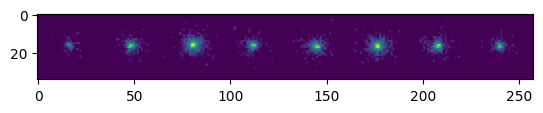

In [16]:
x, y = next(iter(train_loader))
print("Input shape:", x.shape, y.shape)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="viridis");

In [17]:
def corrupt(x: torch.Tensor, amount: torch.Tensor) -> torch.Tensor:
    """
    Corrupt the input `x` by mixing it with noise according to `amount`
    :param amount: torch.Tenosr of shape [x.shape[1], x.shape[2], x.shape[3]]
    """
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + noise * amount

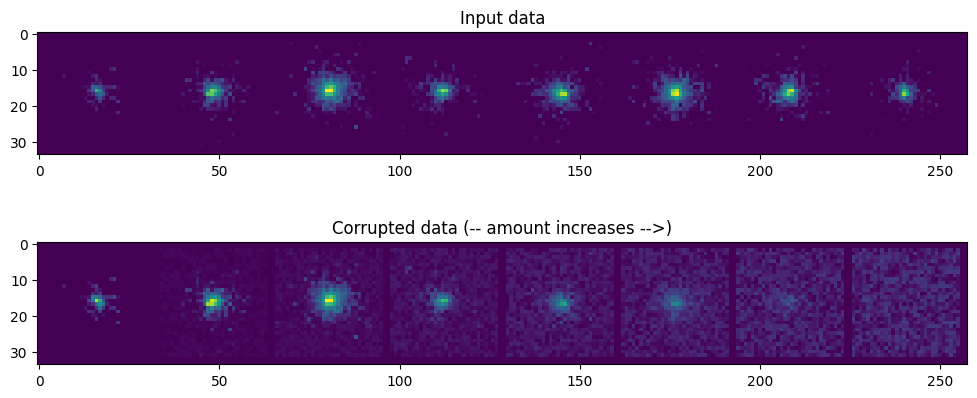

Range of corrupted_train_data: 0.0 5.710546493530273
Range of noise: 1.0788440704345703e-05 0.9998987317085266


In [18]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="viridis")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="viridis");
plt.show()
print("Range of corrupted_train_data:", noised_x.min().item(), noised_x.max().item())
print("Range of noise:", torch.rand_like(noised_x).min().item(), torch.rand_like(noised_x).max().item())

In [19]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, H, W = x.shape
        # Compute query, key, value projections
        q = self.query(x).view(batch_size, -1, H*W).permute(0, 2, 1)  # (B, H*W, C//8)
        k = self.key(x).view(batch_size, -1, H*W)  # (B, C//8, H*W)
        v = self.value(x).view(batch_size, -1, H*W)  # (B, C, H*W)
        
        # Compute attention map
        attention = torch.bmm(q, k)  # (B, H*W, H*W)
        attention = nn.functional.softmax(attention, dim=-1)
        
        # Apply attention to value and combine with residual
        out = torch.bmm(v, attention.permute(0, 2, 1))  # (B, C, H*W)
        out = out.view(batch_size, C, H, W)
        return self.gamma * out + x
        
class MixedConditionedUnet(nn.Module):
    def __init__(self, image_size=30, cond_emb_size=9):
        super().__init__()

        self.image_size = image_size  # Размер входного изображения (30x30)
        self.cond_emb_size = cond_emb_size  # Количество параметров условия

        # Преобразуем вектор условий [bs, 9] в тензор [bs, 128, 2, 2]
        self.fc1 = nn.Linear(cond_emb_size, 128 * 2 * 2)

        # Транспонированные сверточные слои, как в CaloganPhysicsGenerator
        self.conv1 = nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.conv4 = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)

        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(32)

        self.attn2 = SelfAttention(64)
        self.attn3 = SelfAttention(32)

        # UNet принимает изображение + доп. каналы
        self.model = UNet2DModel(
            sample_size=image_size + 2,  # Учитываем паддинг
            in_channels=2,  # 1 канал для изображения + 1 канал для условий
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 128),
            down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
        )

    def forward(self, x, t, condition):
        """
        x         : входное изображение [bs, 1, 30, 30]
        t         : временной шаг (для диффузии)
        condition : вектор условий [bs, 9]
        """
        bs, ch, w, h = x.shape

        # Добавляем паддинг, чтобы получить размер 32x32
        x = torch.nn.functional.pad(x, (1, 1, 1, 1))  # [bs, 1, 32, 32]

        # Кодируем вектор условий в тензор [bs, 128, 2, 2]
        condition_emb = nn.functional.relu(self.fc1(condition)).view(bs, 128, 2, 2)

        # Прогоняем через транспонированные сверточные слои
        EnergyDeposit = nn.functional.relu(self.bn1(self.conv1(condition_emb)))
        EnergyDeposit = nn.functional.relu(self.bn2(self.conv2(EnergyDeposit)))
        EnergyDeposit = self.attn2(EnergyDeposit)
        EnergyDeposit = nn.functional.relu(self.bn3(self.conv3(EnergyDeposit)))
        EnergyDeposit = self.attn3(EnergyDeposit)
        EnergyDeposit = nn.functional.relu(self.conv4(EnergyDeposit))

        # Обрезаем до [bs, 1, 30, 30]
        EnergyDeposit = EnergyDeposit[:, :, 1:31, 1:31]

        # Добавляем паддинг, чтобы получить размер 32x32
        EnergyDeposit = torch.nn.functional.pad(EnergyDeposit, (1, 1, 1, 1))  # [bs, 1, 32, 32]

        # Объединяем изображение и условие по каналу
        net_input = torch.cat((x, EnergyDeposit), 1)  # [bs, 2, 32, 32]

        # Прогоняем через UNet
        output = x - self.model(net_input, t).sample  # [bs, 1, 32, 32]

        # Обрезаем до [bs, 1, 30, 30] перед возвратом
        return output[:, :, 1:-1, 1:-1]

In [20]:
def add_noise(arr):
    noise_coefs = 1 + np.random.normal(0, 0.1, size=arr.shape)
    return arr * noise_coefs

In [21]:
def get_test_data(global_config):
    """
    Примеры данных для визуализации (отбирались вручную)
    """
    data_train = np.load(os.path.join(global_config.paths.data_dir_path,
                                      'caloGAN_case11_5D_120K.npz'))
    samples_indices = [0, 31516, 62946, 37323, 57956]

    point = torch.tensor(data_train['ParticlePoint'][samples_indices]).float()
    momentum = torch.tensor(data_train['ParticleMomentum'][samples_indices]).float() 
    pt = torch.sqrt(momentum[:, 0]**2 + momentum[:, 1]**2)
    eta = -torch.log(pt / momentum[:, 2])
    phi = torch.atan2(momentum[:, 0], momentum[:, 1])
    
    momentum_cyl = torch.stack([pt, eta, phi], dim=1)
    
    total_energy_sci = torch.tensor(data_train['TotalEnergySci'][samples_indices]).float()
    total_energy_sci_norm = (total_energy_sci / total_energy_sci.max()).unsqueeze(1)  # [0, 1]

    total_energy_absorb = torch.tensor(data_train['TotalEnergyAbsorb'][samples_indices]).float()
    total_energy_absorb_norm = (total_energy_absorb / total_energy_absorb.max()).unsqueeze(1)  # [0, 1]
    
    momentum_norm = momentum / torch.norm(momentum, dim=1, keepdim=True)
    point_norm = point / torch.norm(point, dim=1, keepdim=True)
    
    pure_physic_condition = torch.cat([momentum_norm,
                                       momentum_cyl,
                                       point_norm], dim=1)
    
    energy = torch.tensor(data_train['EnergyDeposit'][samples_indices]).float()
    energy = torch.permute(energy, dims=(0, 3, 1, 2))
    
    return energy, pure_physic_condition

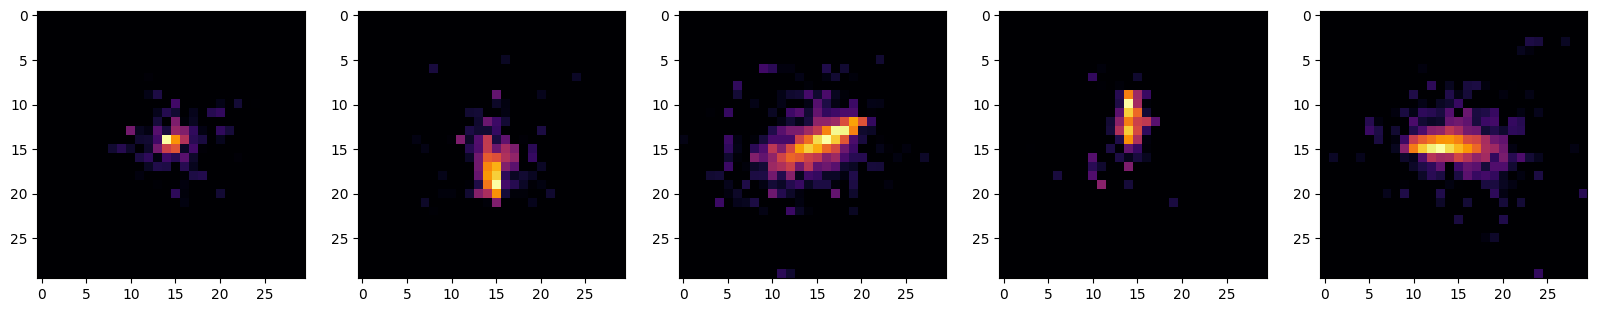

In [22]:
### Эта часть посвящена получению тестовых данных и логгированию их на WandB (сейчас не работает) 


from pipeline.config import GlobalConfig, PathsConfig #WandB
from pipeline.device import get_local_device #WandB
from visualization_aux.visualize_physics import energy_imshow # простая функция imshow, 
                                        #обернутая в функцию с возможными дополнениями в виде афинных преобразований
                                        #или более физического представления

global_config = GlobalConfig(paths=PathsConfig('data_demo', './experiments'), logger=None)
# отобранные вручную объекты датасеты с разными условиями
visualization_data = get_test_data(global_config)


# истинные значения для выбранных условий
fig, axs = plt.subplots(1, len(visualization_data[0]), figsize=(20, 5))

for ax, x in zip(axs, visualization_data[0]):
    energy_imshow(energy=torch.Tensor(x), ax=ax)

plt.show()
test_data = PhysicsDataset(torch.Tensor(visualization_data[0]),
                                torch.Tensor(visualization_data[1]))

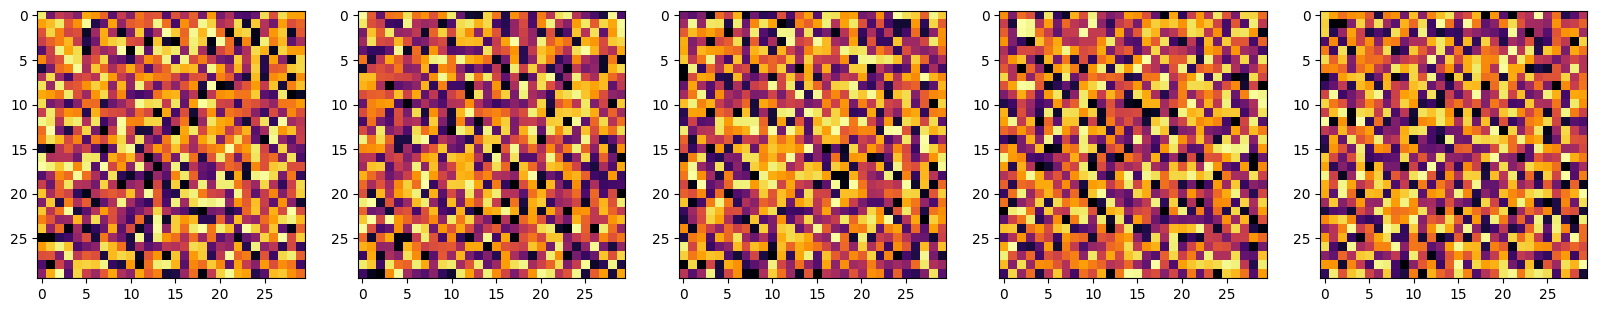

In [23]:
# Добавление шума на картинки тестовых данных, не используется  при визуализации данных,
#так как генерация идет из нормального распределения сразу
amount_test = torch.linspace(1, 1, visualization_data[0].shape[0])
noised_x_test = corrupt(torch.Tensor(visualization_data[0]), amount_test)

test_data = PhysicsDataset(noised_x_test,
                                torch.Tensor(visualization_data[1]))

fig, axs = plt.subplots(1, len(noised_x_test), figsize=(20, 5))
for ax, x in zip(axs, noised_x_test):
    energy_imshow(energy=torch.Tensor(x), ax=ax)

plt.show()

In [24]:
# Кастомная функция, которая старается минимизировать расстояние между распределениями сгенерированных и реальных картинок

def energy_distance_loss(real, fake):
    """
    Функция потерь, основанная на Energy Distance.
    :param real: torch.Tensor с реальными данными, размерность [batch_size, ...]
    :param fake: torch.Tensor с сгенерированными данными, размерность [batch_size, ...]
    :return: Energy Distance Loss (torch.Tensor)
    """
    def pairwise_distance(x, y):
        return torch.cdist(x.flatten(start_dim=1), y.flatten(start_dim=1), p=2)

    dist_rr = pairwise_distance(real, real).mean()
    dist_ff = pairwise_distance(fake, fake).mean()
    dist_rf = pairwise_distance(real, fake).mean()
    
    return 2 * dist_rf - dist_rr - dist_ff

In [25]:
### Валидация 

# Создаем списки для хранения всех x и y
all_x = []
all_y = []

# Проходим по всему DataLoader и собираем данные
for x_batch, y_batch in valid_loader:
    all_x.append(x_batch)
    all_y.append(y_batch)

# Объединяем все батчи в один большой тензор
real_images_valid = torch.cat(all_x, dim=0)
y_valid = torch.cat(all_y, dim=0)

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 1: Avg Loss (Energy Distance): 1.14842


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


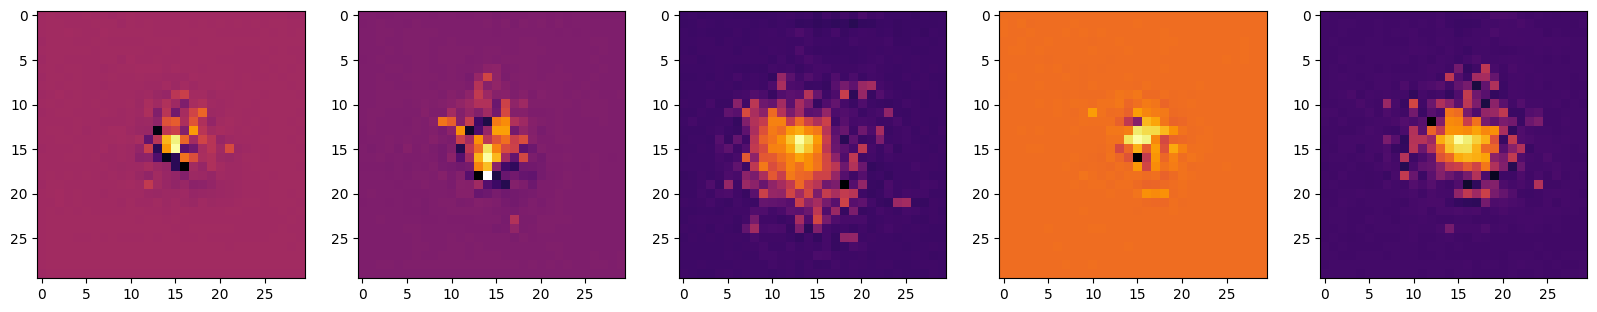

['__notebook__.ipynb', 'data_demo', 'checkpoint_epoch_1.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 2: Avg Loss (Energy Distance): 0.92605


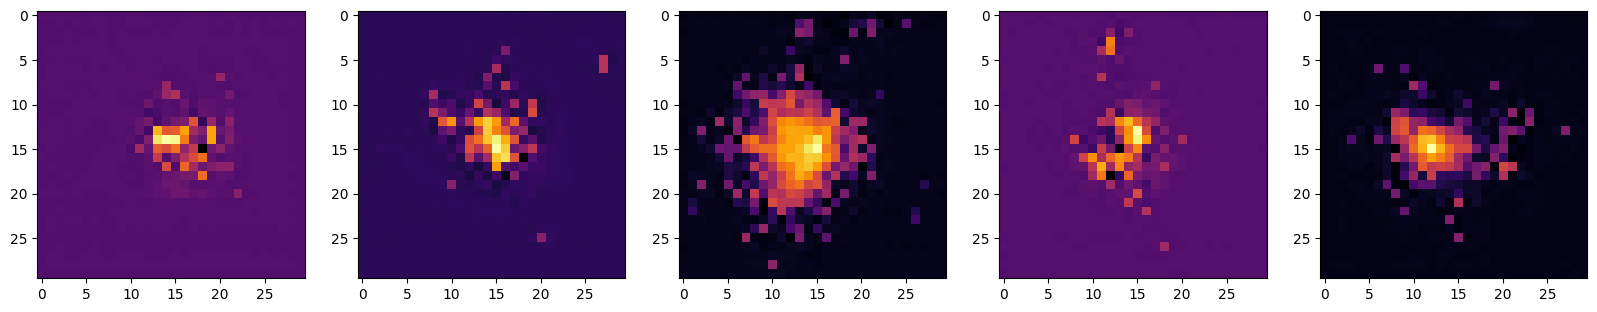

['checkpoint_epoch_2.pth', '__notebook__.ipynb', 'data_demo', 'checkpoint_epoch_1.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 3: Avg Loss (Energy Distance): 0.88937


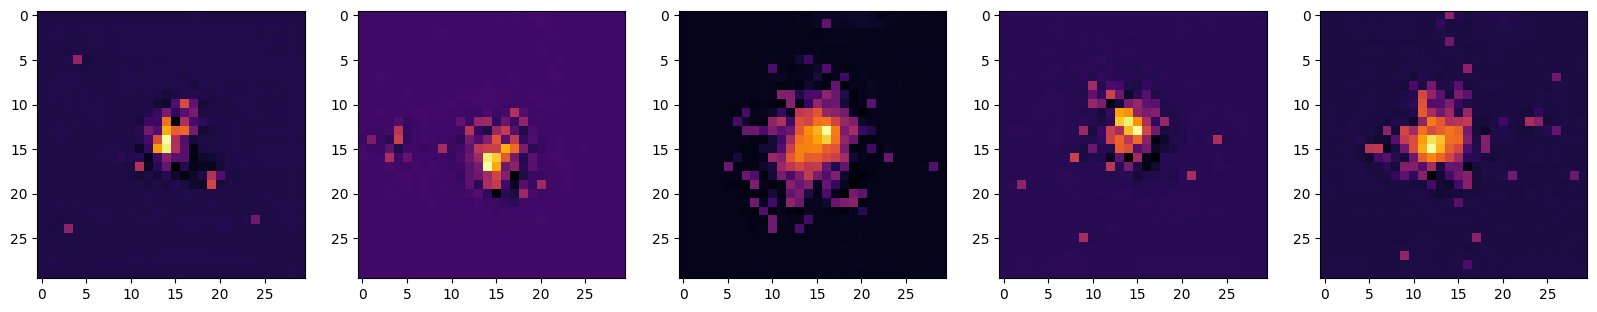

['checkpoint_epoch_2.pth', '__notebook__.ipynb', 'data_demo', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 4: Avg Loss (Energy Distance): 0.87464


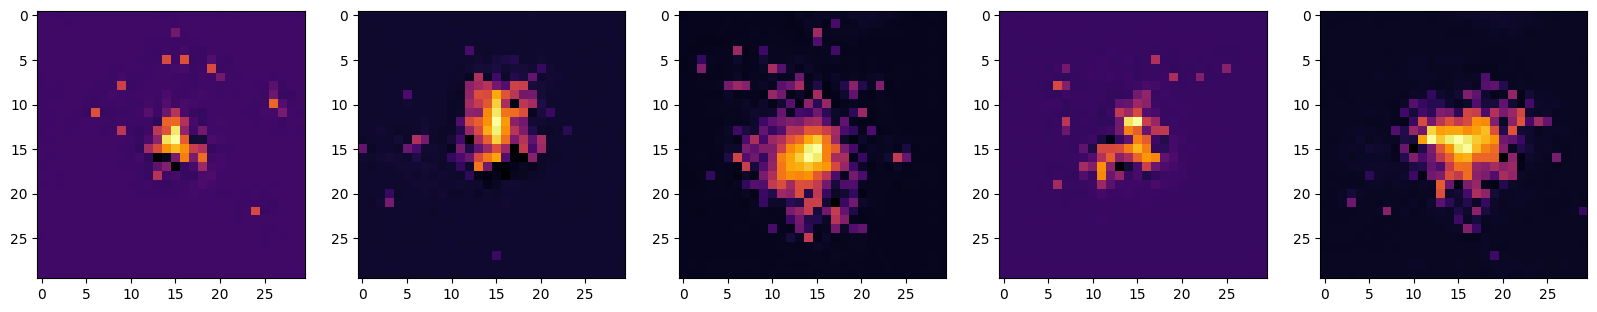

['checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_4.pth', 'data_demo', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 5: Avg Loss (Energy Distance): 0.86263


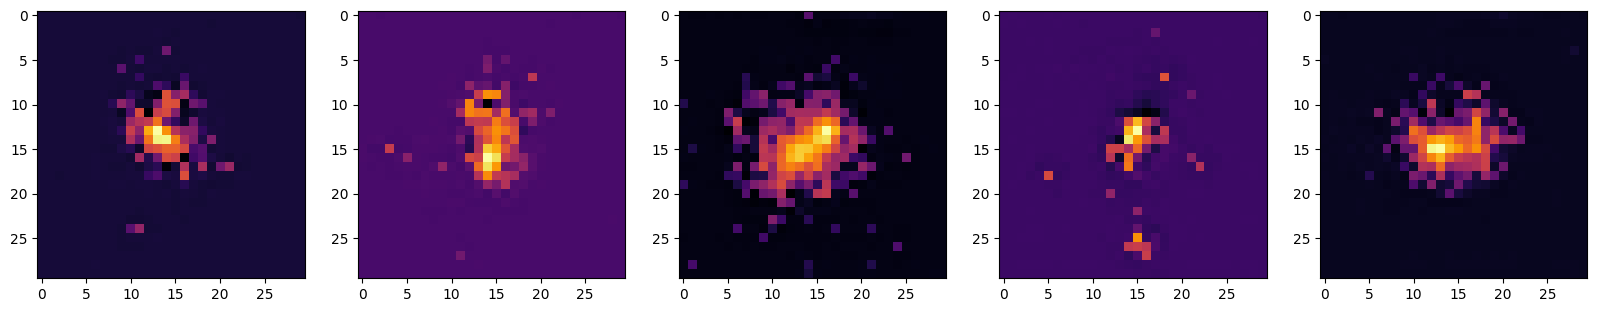

['checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_4.pth', 'data_demo', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 6: Avg Loss (Energy Distance): 0.85696


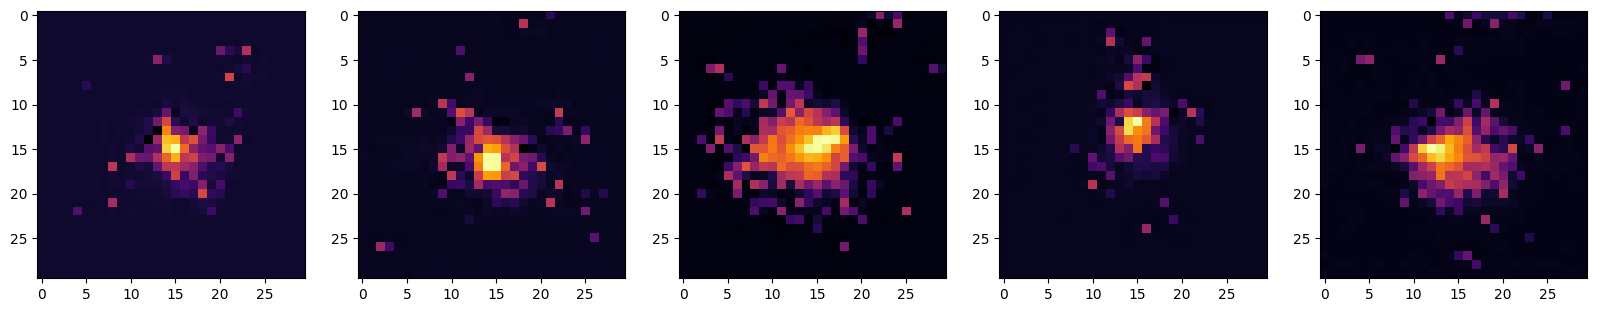

['checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_4.pth', 'data_demo', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 7: Avg Loss (Energy Distance): 0.84716


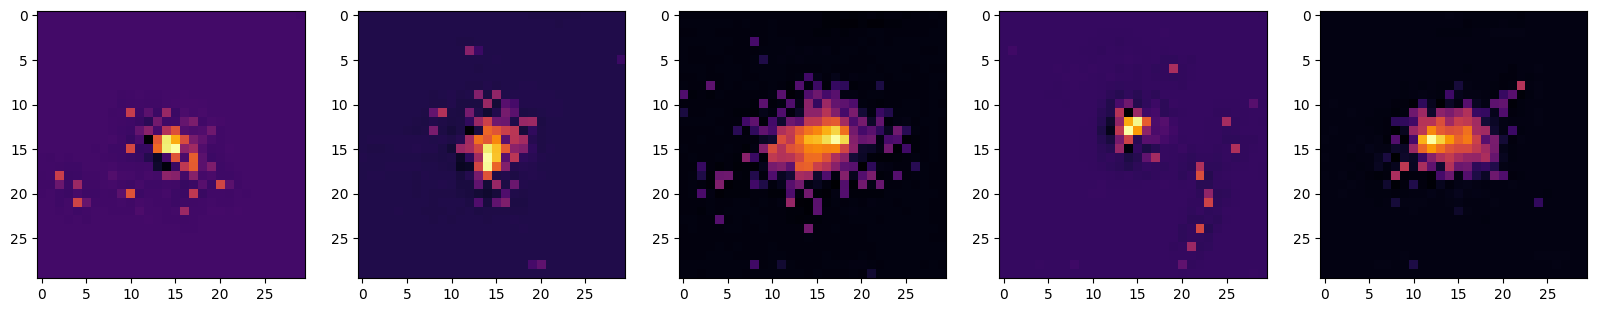

['checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'data_demo', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 8: Avg Loss (Energy Distance): 0.83917


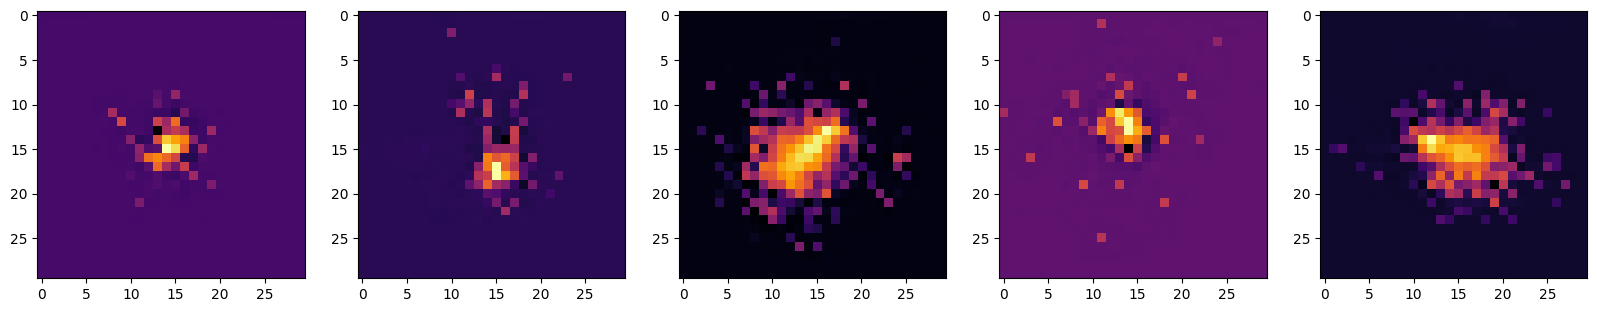

['checkpoint_epoch_8.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'data_demo', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 9: Avg Loss (Energy Distance): 0.84043


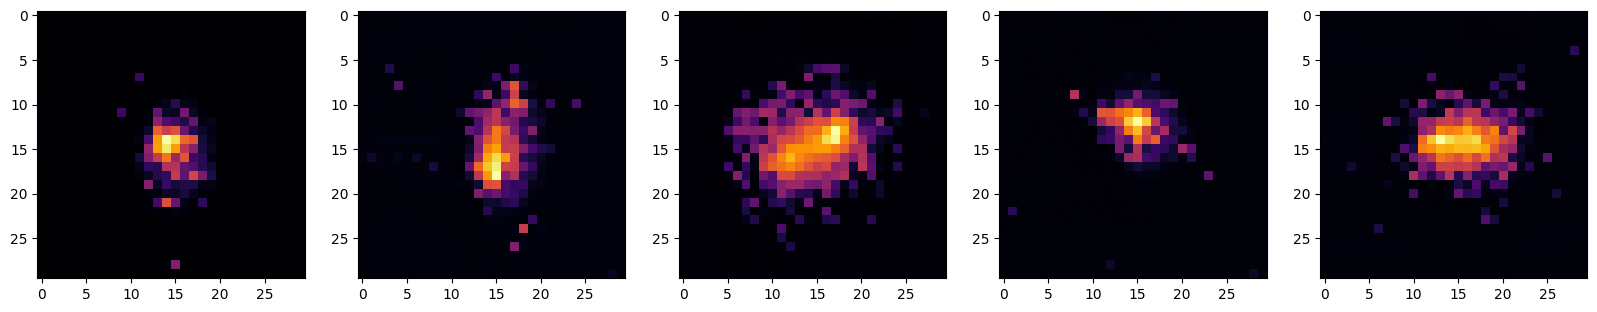

['checkpoint_epoch_8.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 10: Avg Loss (Energy Distance): 0.82987


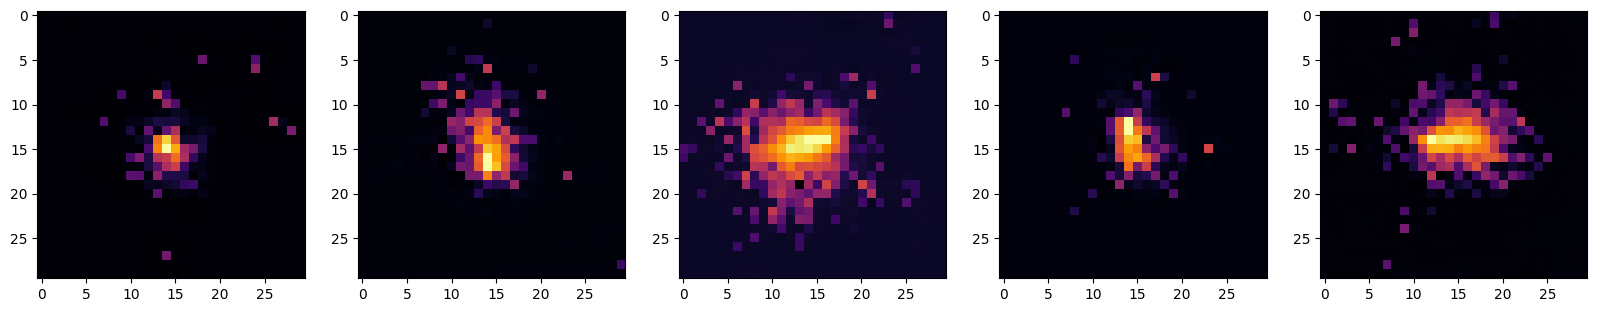

['checkpoint_epoch_8.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 11: Avg Loss (Energy Distance): 0.83018


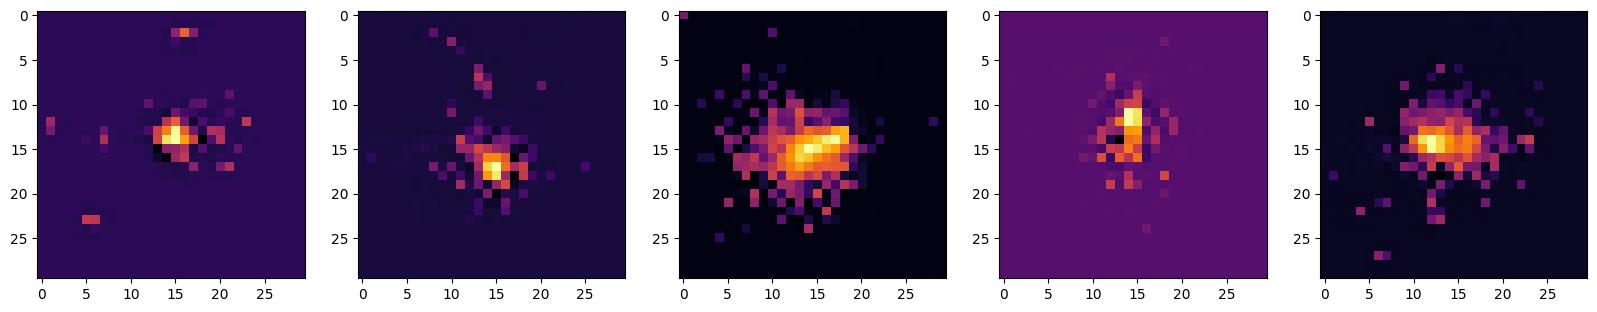

['checkpoint_epoch_8.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 12: Avg Loss (Energy Distance): 0.82640


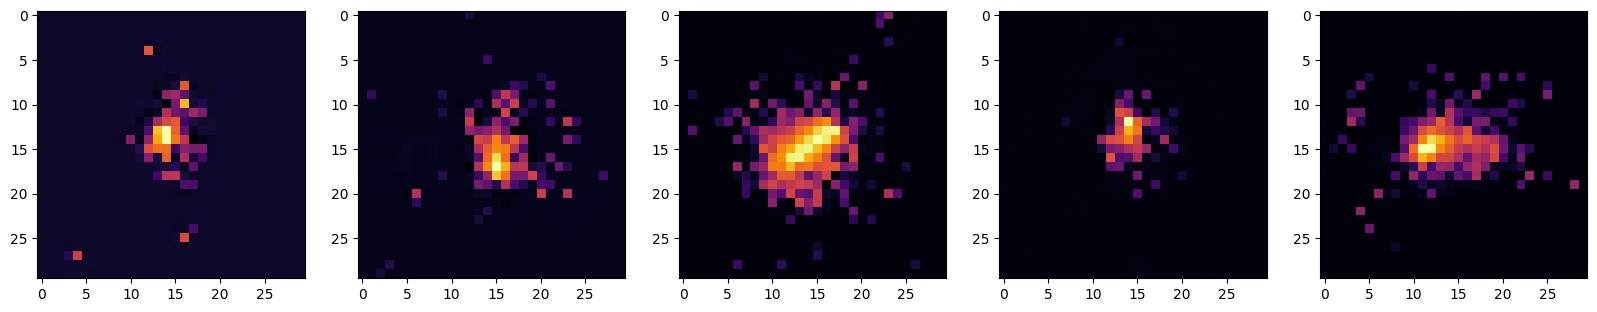

['checkpoint_epoch_8.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 13: Avg Loss (Energy Distance): 0.82313


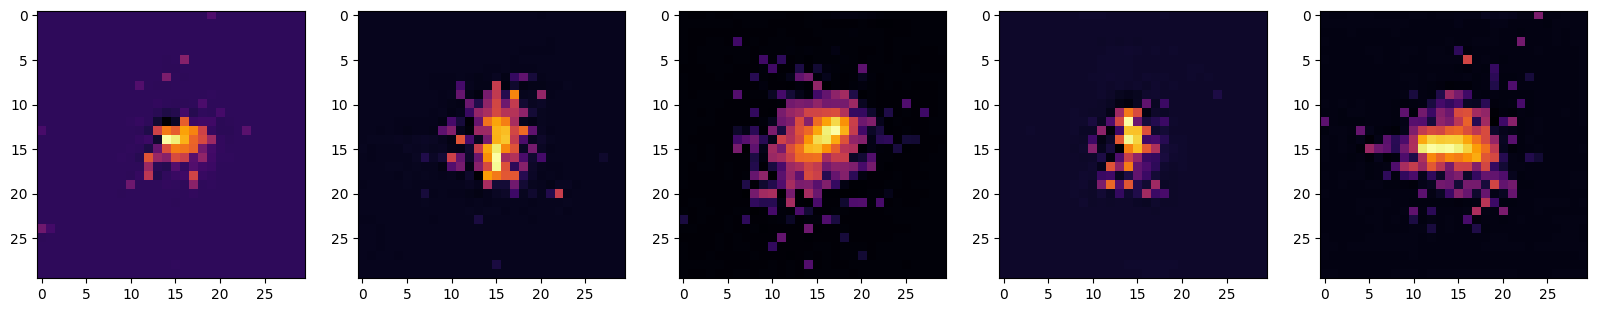

['checkpoint_epoch_8.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 14: Avg Loss (Energy Distance): 0.81953


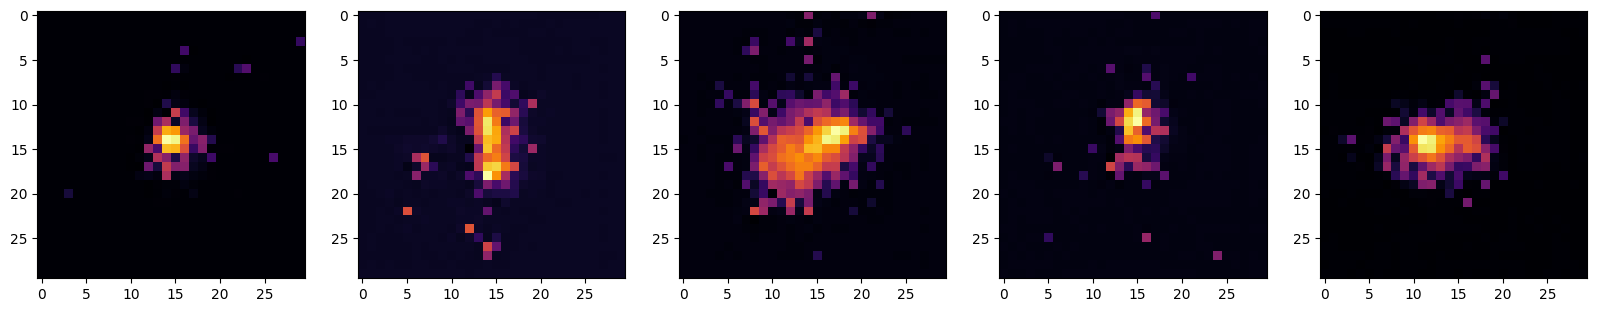

['checkpoint_epoch_8.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 15: Avg Loss (Energy Distance): 0.81677


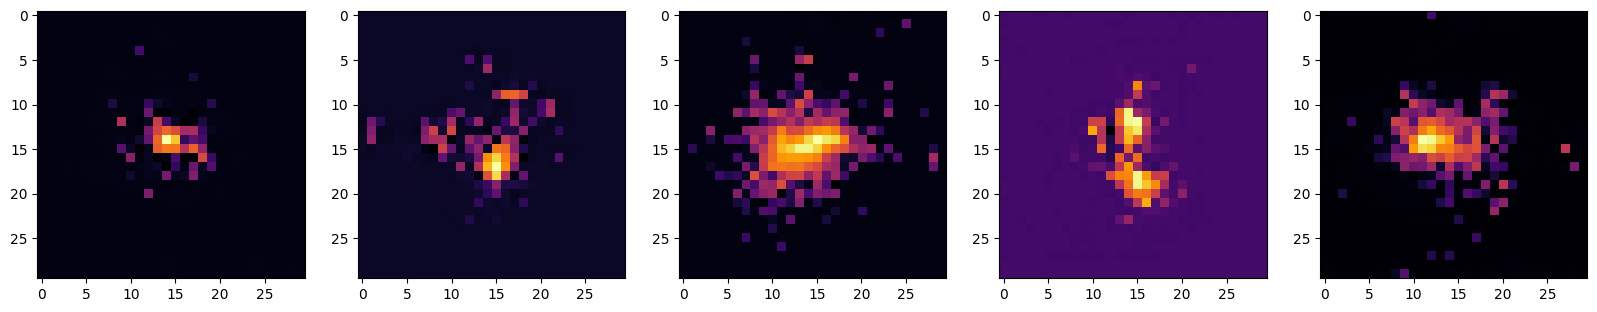

['checkpoint_epoch_8.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 16: Avg Loss (Energy Distance): 0.81316


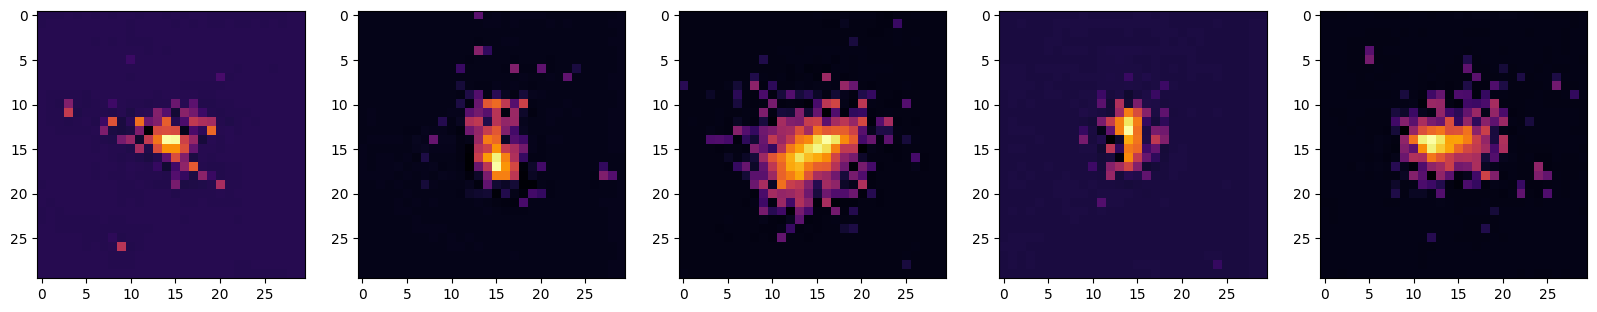

['checkpoint_epoch_8.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 17: Avg Loss (Energy Distance): 0.81343


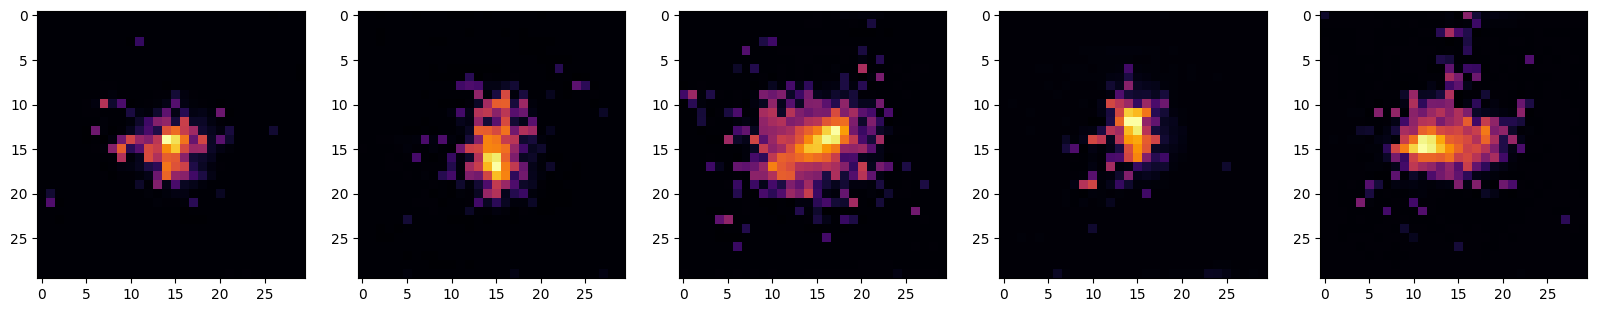

['checkpoint_epoch_8.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 18: Avg Loss (Energy Distance): 0.81015


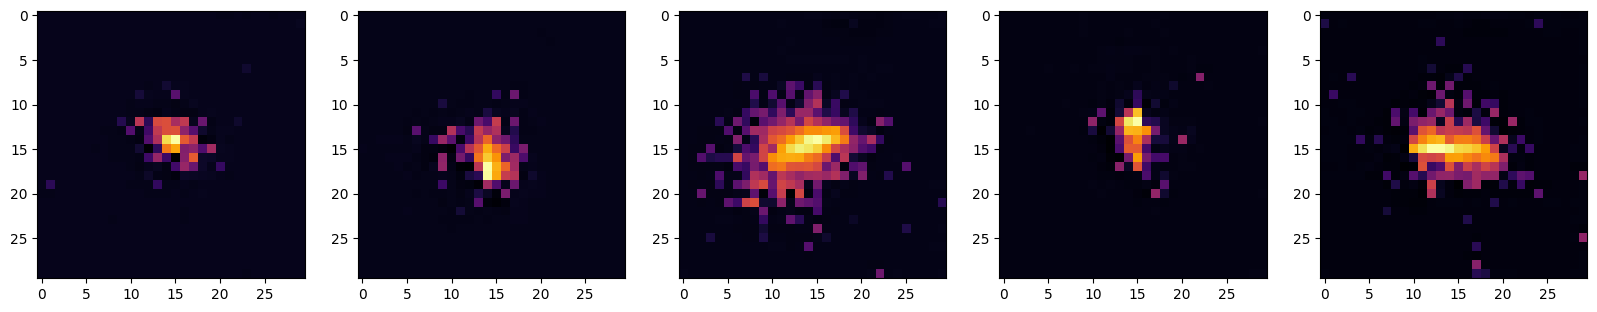

['checkpoint_epoch_8.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 19: Avg Loss (Energy Distance): 0.81066


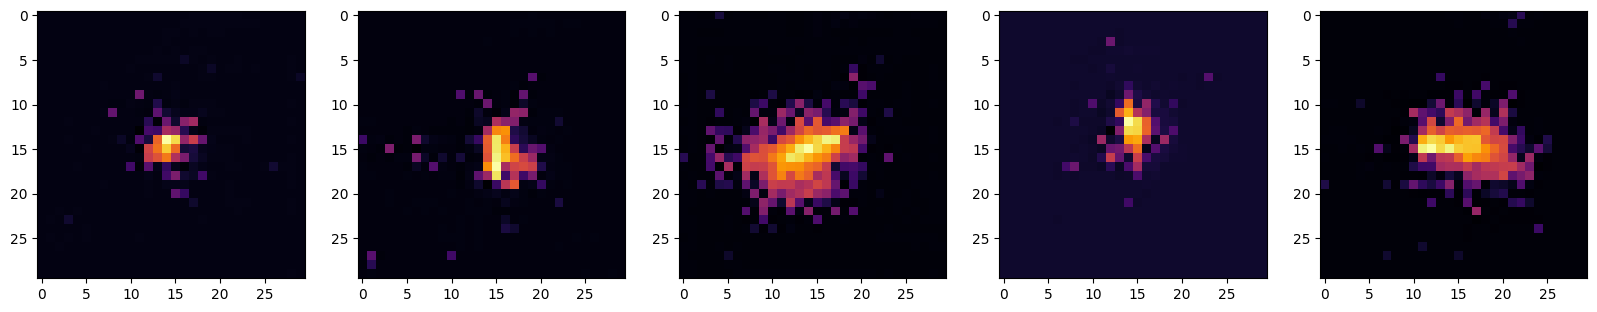

['checkpoint_epoch_8.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 20: Avg Loss (Energy Distance): 0.80481


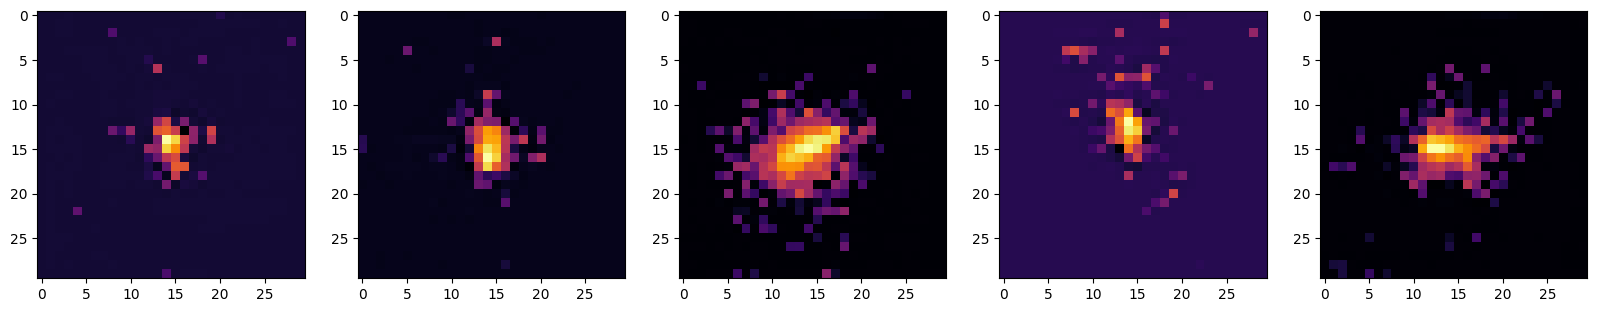

['checkpoint_epoch_8.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 21: Avg Loss (Energy Distance): 0.80746


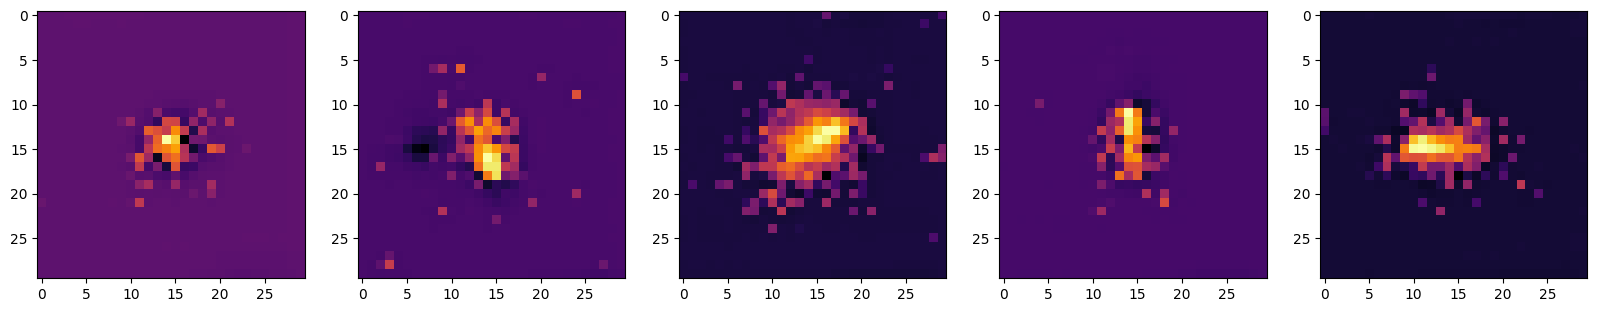

['checkpoint_epoch_8.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 22: Avg Loss (Energy Distance): 0.79934


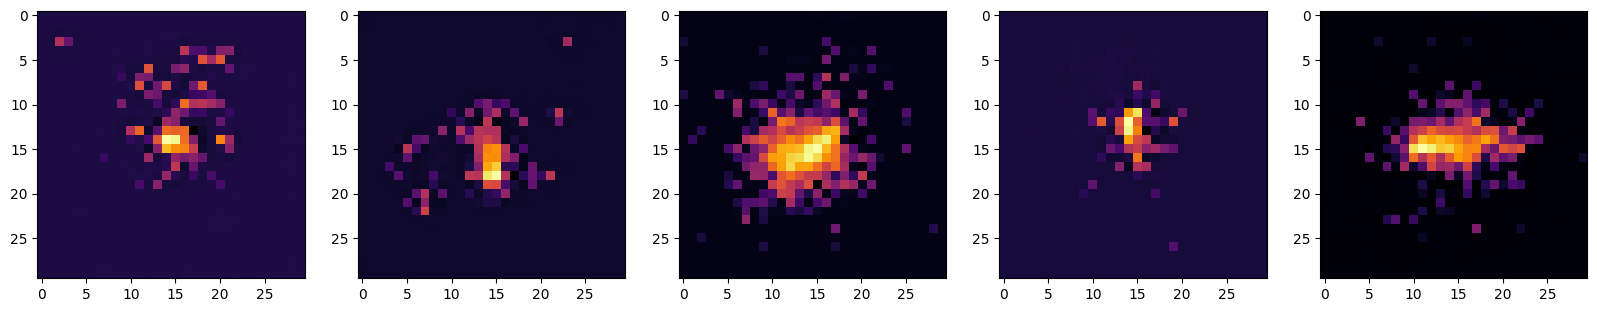

['checkpoint_epoch_8.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', '__notebook__.ipynb', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 23: Avg Loss (Energy Distance): 0.80311


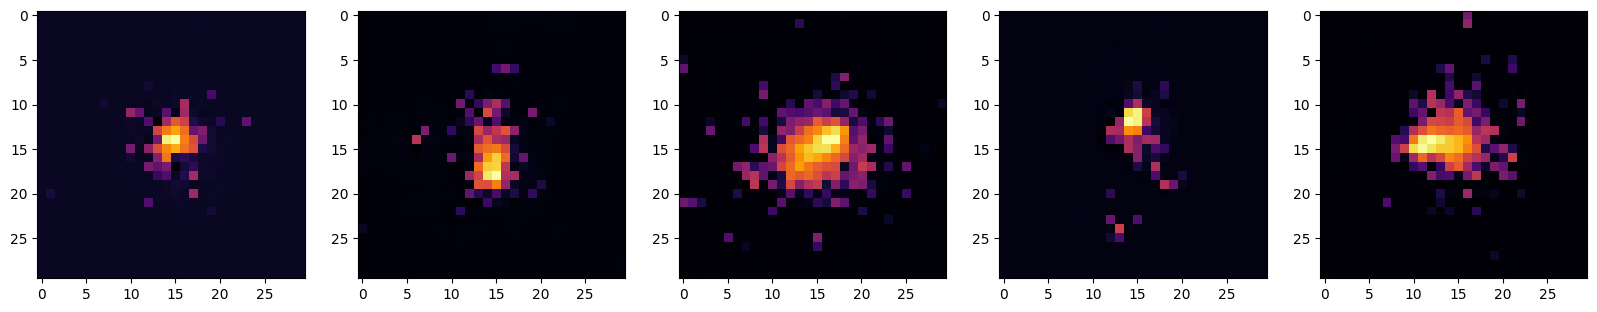

['checkpoint_epoch_8.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 24: Avg Loss (Energy Distance): 0.80192


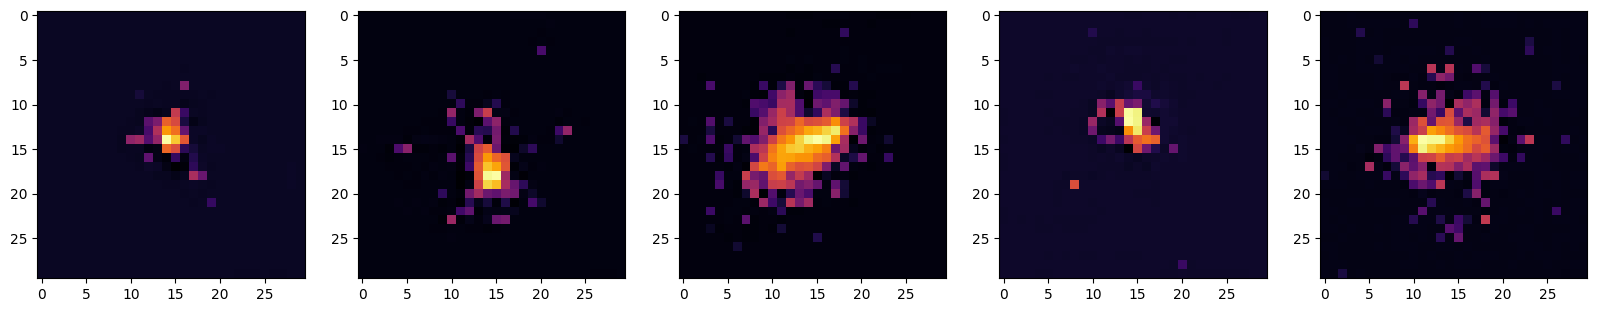

['checkpoint_epoch_8.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 25: Avg Loss (Energy Distance): 0.80325


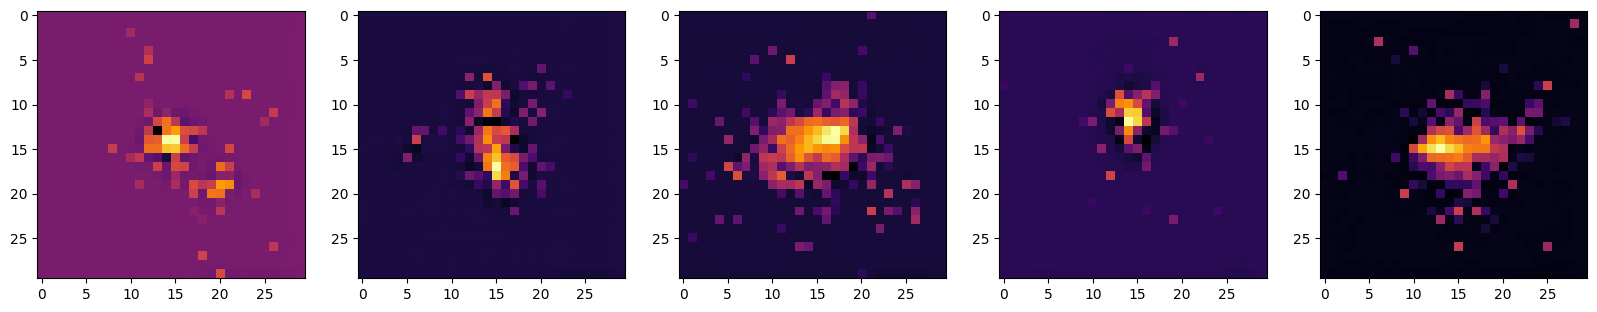

['checkpoint_epoch_8.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 26: Avg Loss (Energy Distance): 0.80001


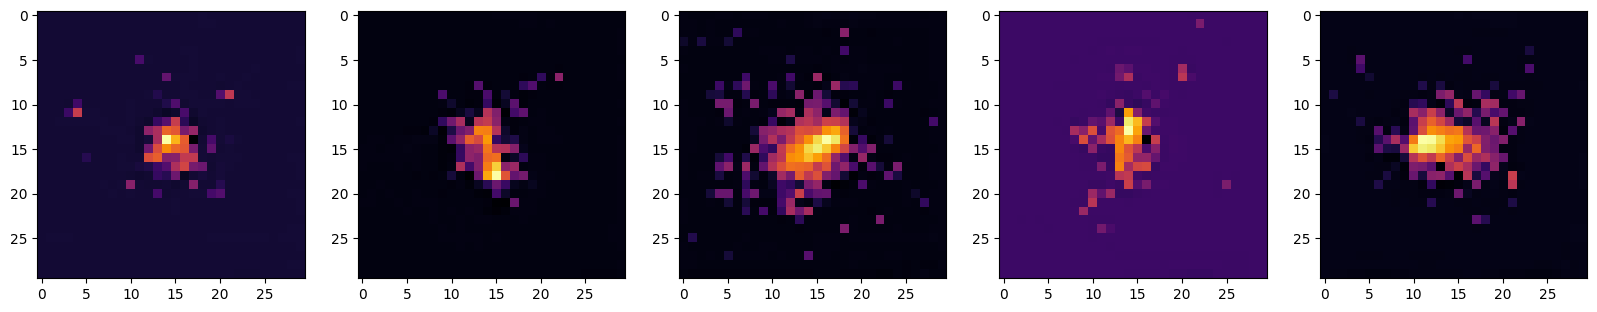

['checkpoint_epoch_8.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 27: Avg Loss (Energy Distance): 0.79837


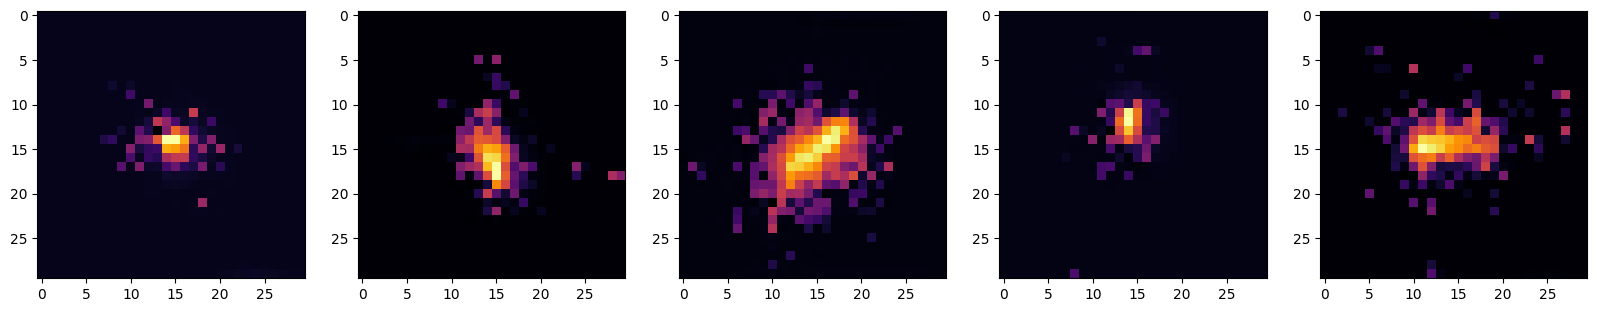

['checkpoint_epoch_8.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 28: Avg Loss (Energy Distance): 0.80142


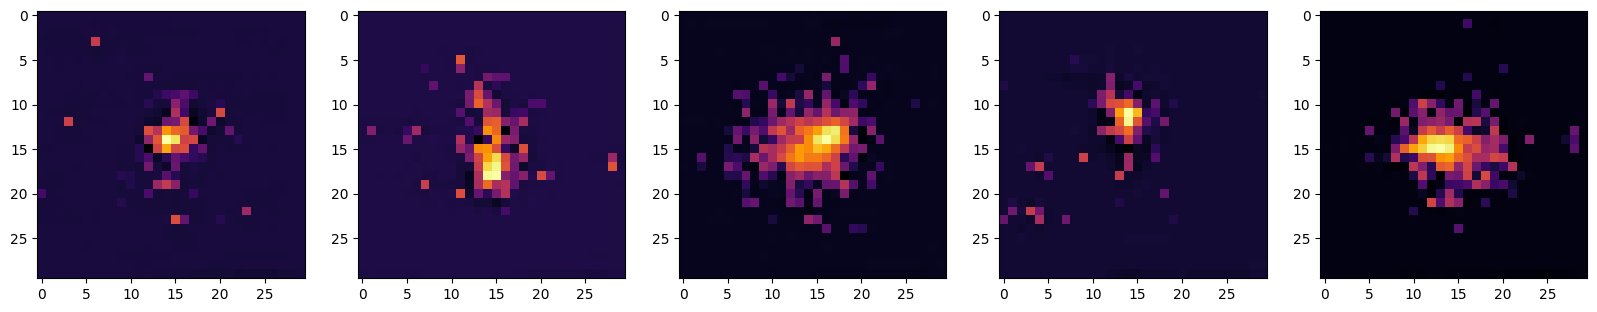

['checkpoint_epoch_8.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_28.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 29: Avg Loss (Energy Distance): 0.79549


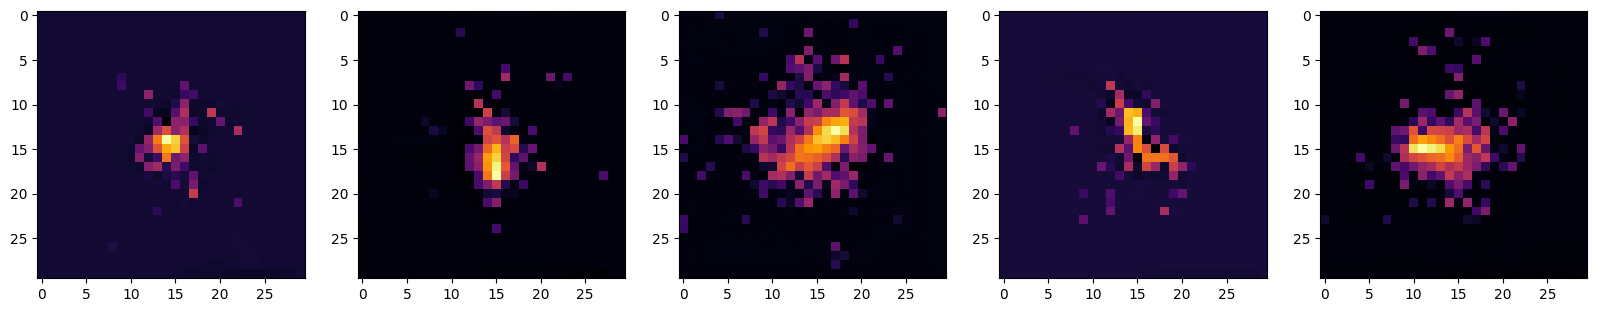

['checkpoint_epoch_8.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_28.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 30: Avg Loss (Energy Distance): 0.79475


  0%|          | 0/10 [00:00<?, ?it/s]

/kaggle/input/gan-lib/pipeline/physical_metrics/calogan_metrics.py:83: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sum_2 - sum_1 * sum_1)


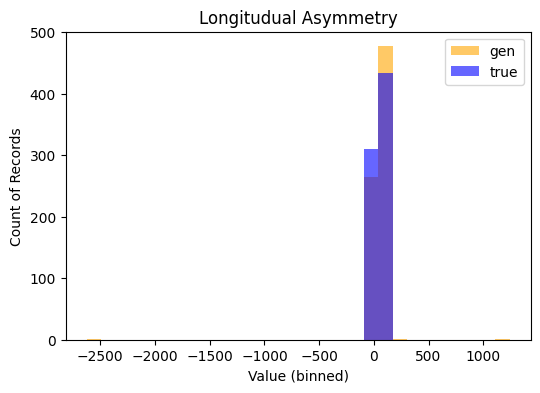

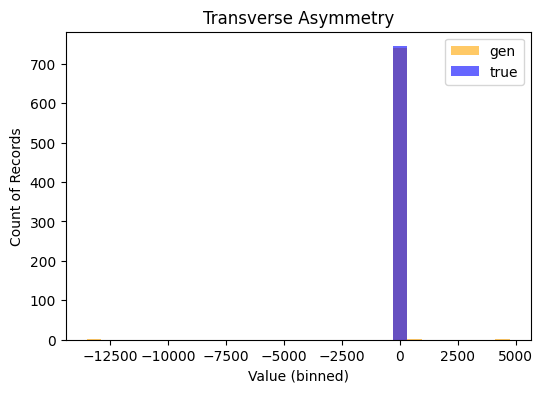

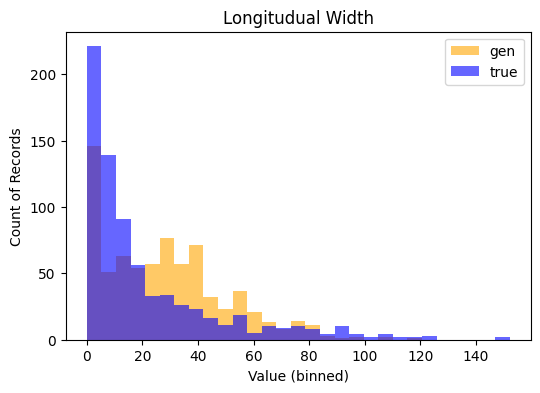

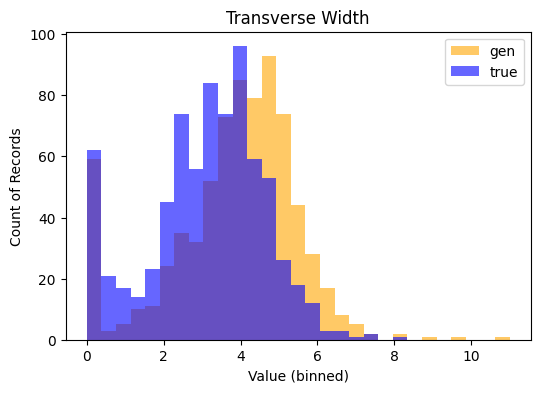

Energy PRD


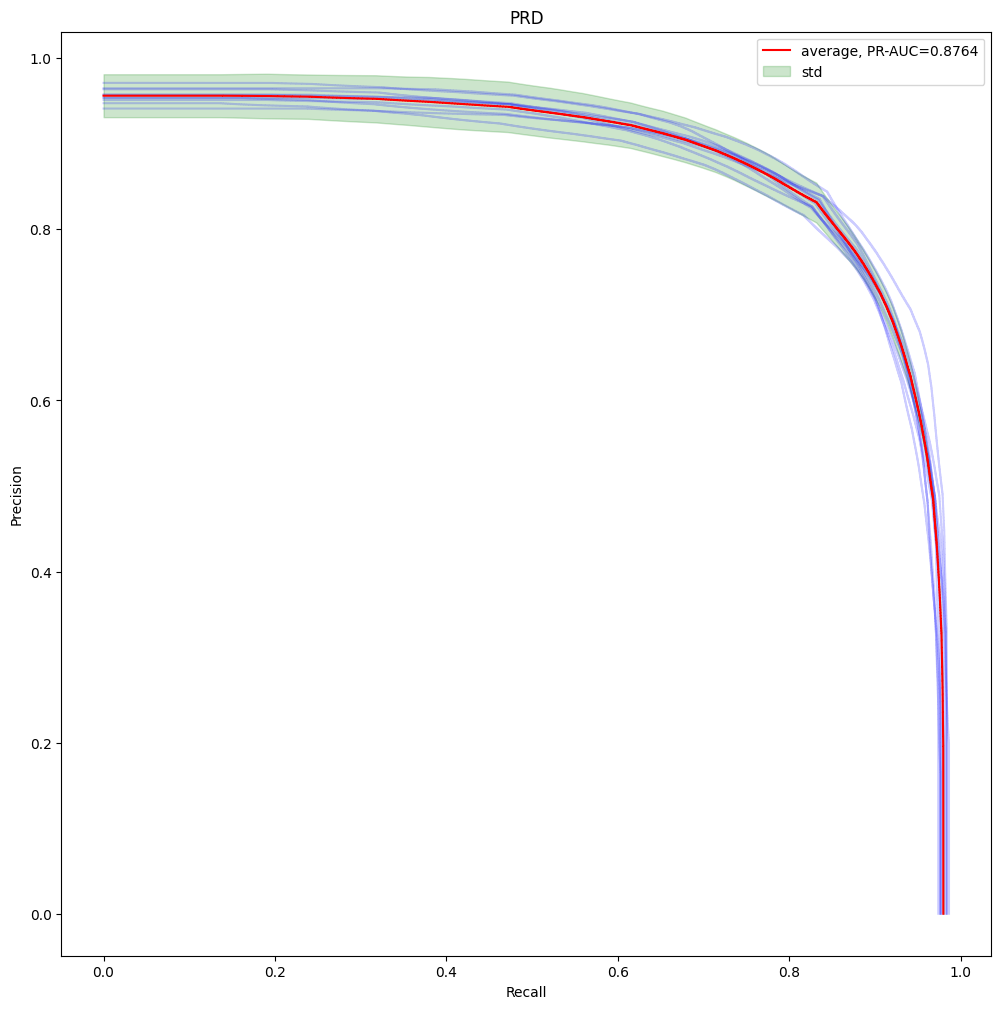

Physics PRD


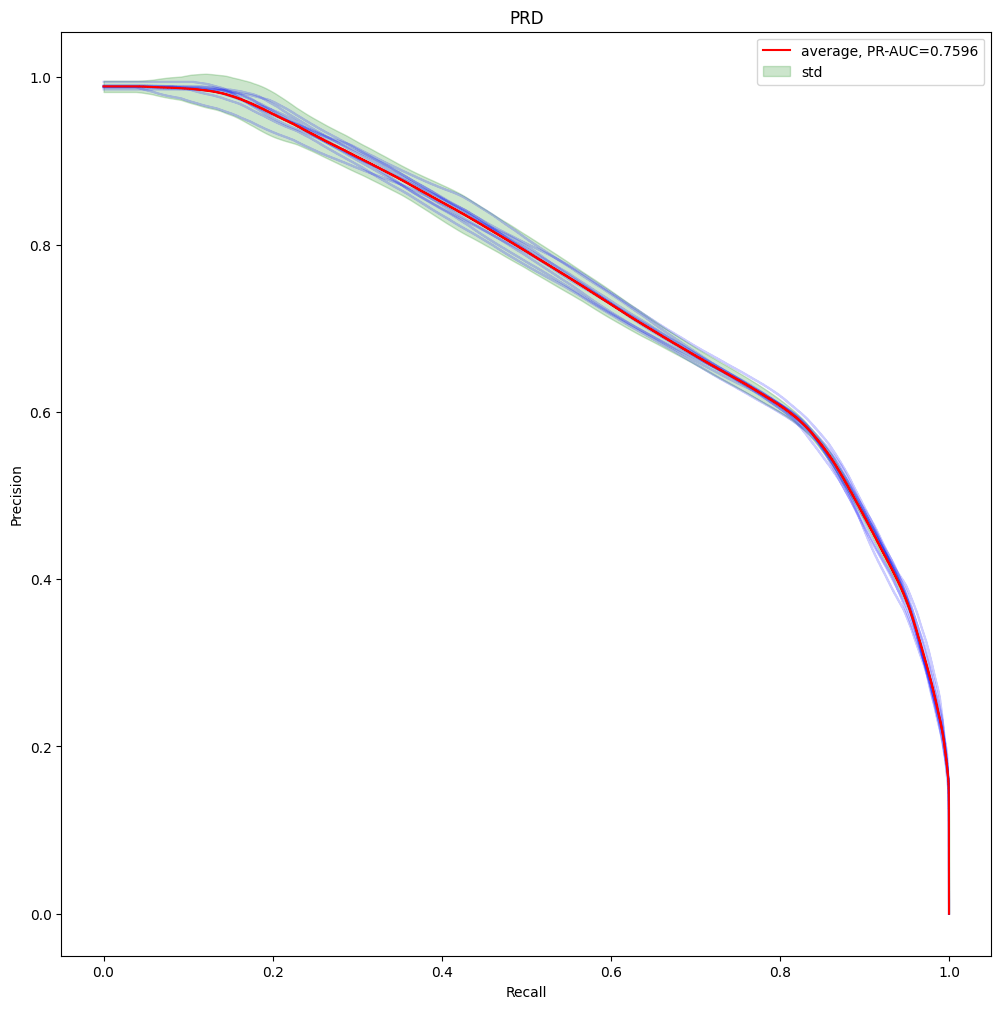

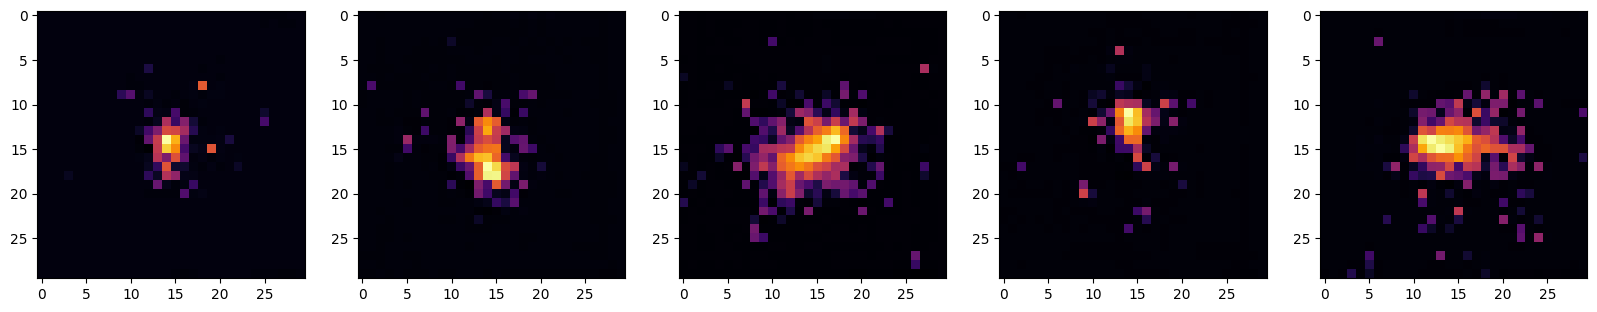

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_28.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 31: Avg Loss (Energy Distance): 0.79651


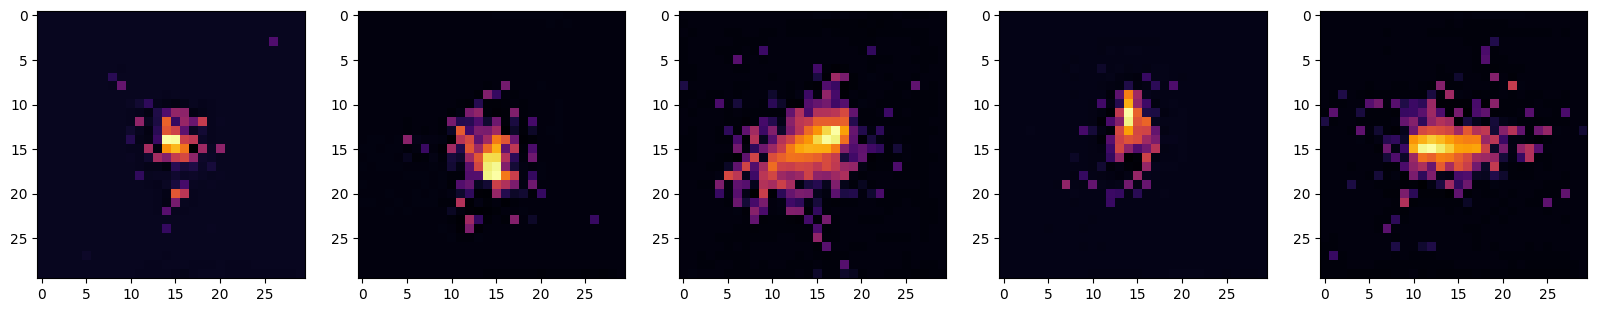

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_31.pth', 'checkpoint_epoch_28.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 32: Avg Loss (Energy Distance): 0.79515


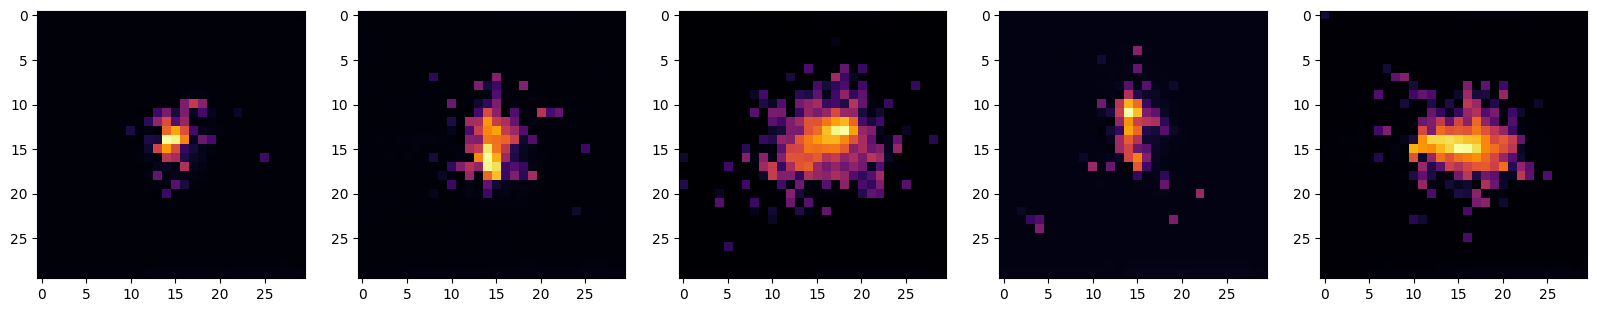

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_32.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_31.pth', 'checkpoint_epoch_28.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 33: Avg Loss (Energy Distance): 0.79775


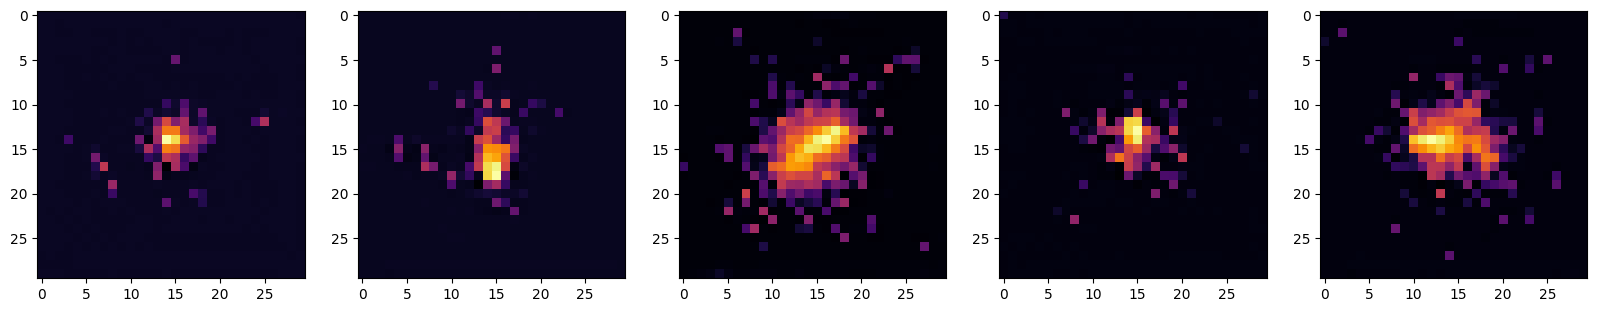

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_32.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_33.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_31.pth', 'checkpoint_epoch_28.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 34: Avg Loss (Energy Distance): 0.79569


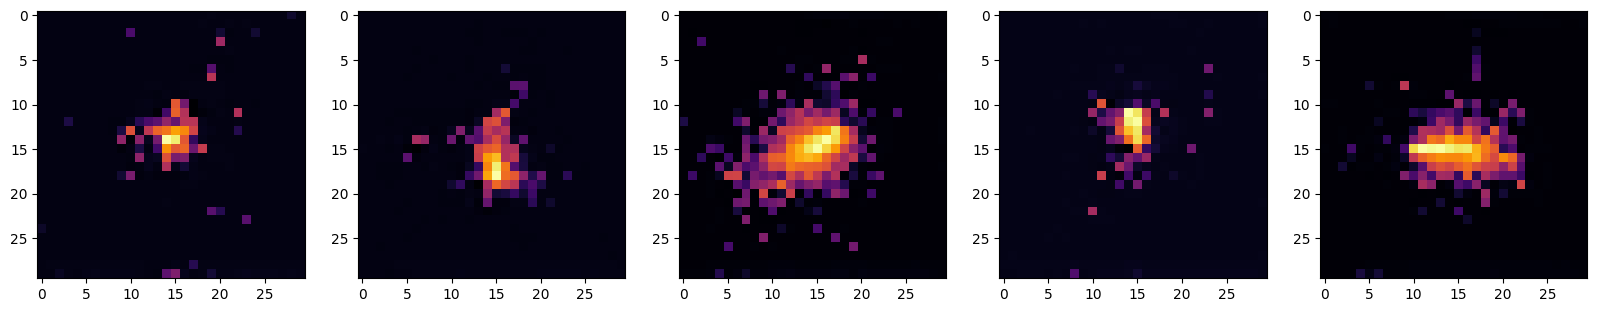

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_34.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_32.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_33.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_31.pth', 'checkpoint_epoch_28.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 35: Avg Loss (Energy Distance): 0.79370


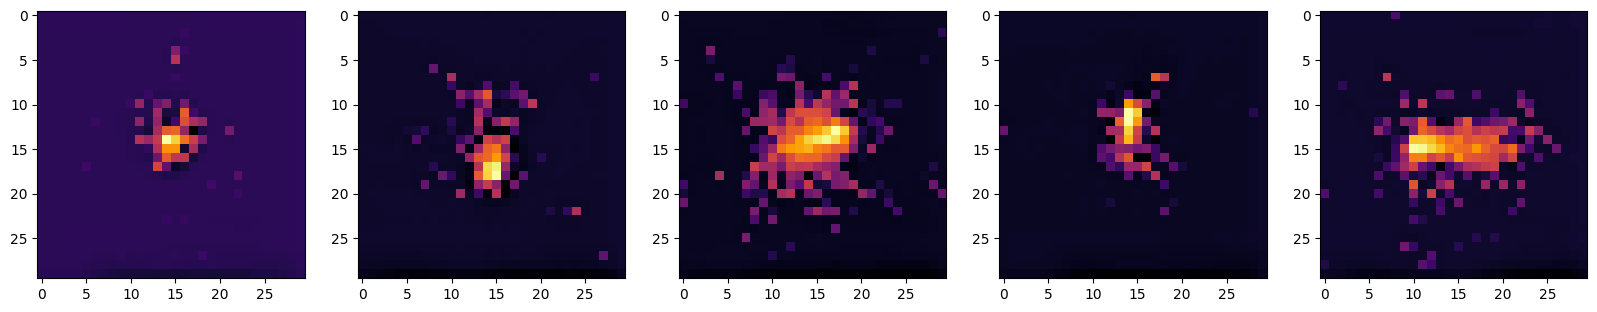

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_34.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_32.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_33.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_31.pth', 'checkpoint_epoch_35.pth', 'checkpoint_epoch_28.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 36: Avg Loss (Energy Distance): 0.79749


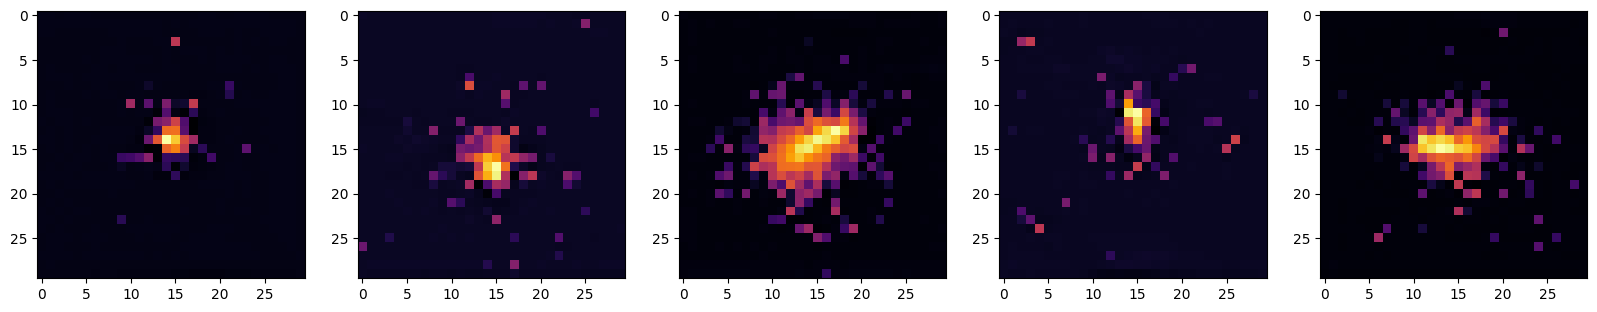

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_34.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_32.pth', 'checkpoint_epoch_36.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_33.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_31.pth', 'checkpoint_epoch_35.pth', 'checkpoint_epoch_28.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth']


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 37: Avg Loss (Energy Distance): 0.79182


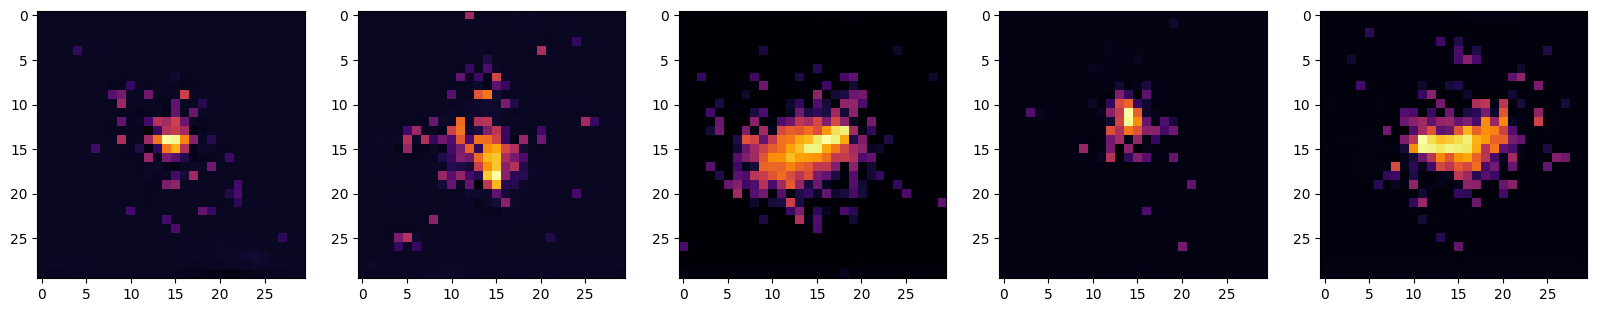

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_34.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_32.pth', 'checkpoint_epoch_36.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_33.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_31.pth', 'checkpoint_epoch_35.pth', 'checkpoint_epoch_28.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_5.pth', '

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 38: Avg Loss (Energy Distance): 0.79298


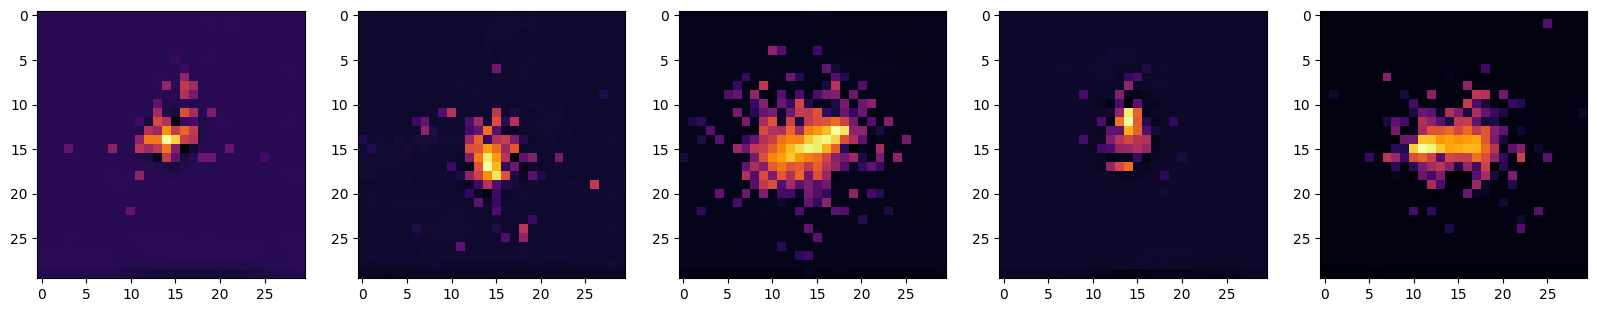

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_34.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_32.pth', 'checkpoint_epoch_36.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_38.pth', 'checkpoint_epoch_33.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_31.pth', 'checkpoint_epoch_35.pth', 'checkpoint_epoch_28.pth', 'checkpoint_epoch_10.pth', 

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 39: Avg Loss (Energy Distance): 0.79259


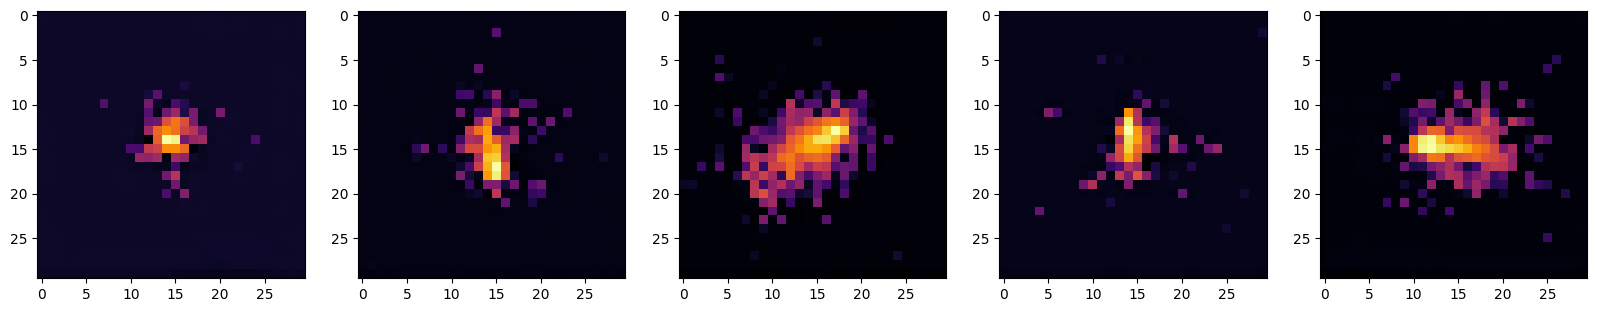

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_39.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_34.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_32.pth', 'checkpoint_epoch_36.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_38.pth', 'checkpoint_epoch_33.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_31.pth', 'checkpoint_epoch_35.pth', 'checkpoint_epoch_28.pth', 

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 40: Avg Loss (Energy Distance): 0.79255


  0%|          | 0/10 [00:00<?, ?it/s]

/kaggle/input/gan-lib/pipeline/physical_metrics/calogan_metrics.py:83: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sum_2 - sum_1 * sum_1)


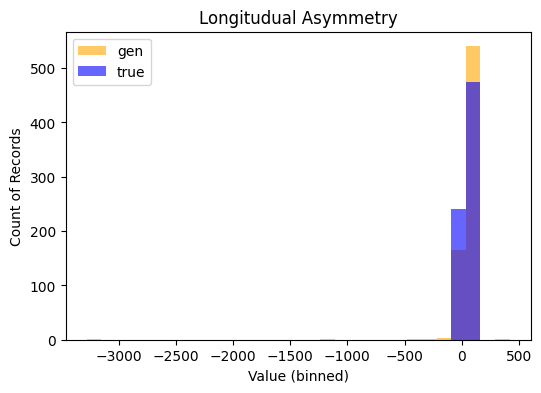

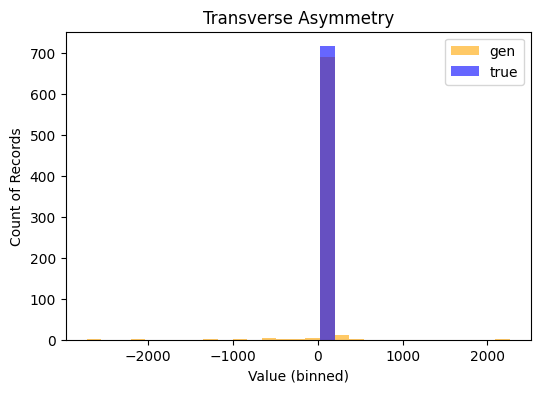

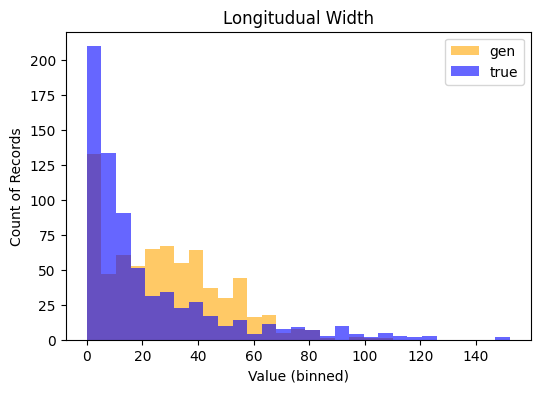

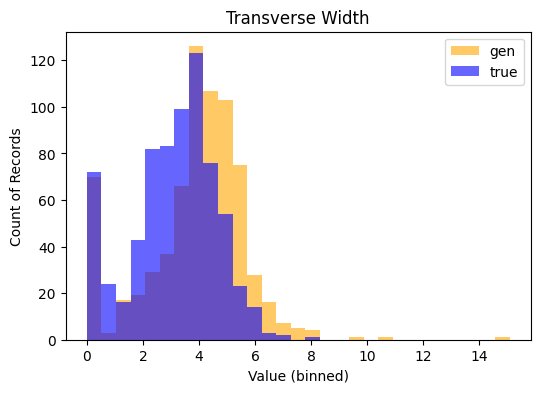

Energy PRD


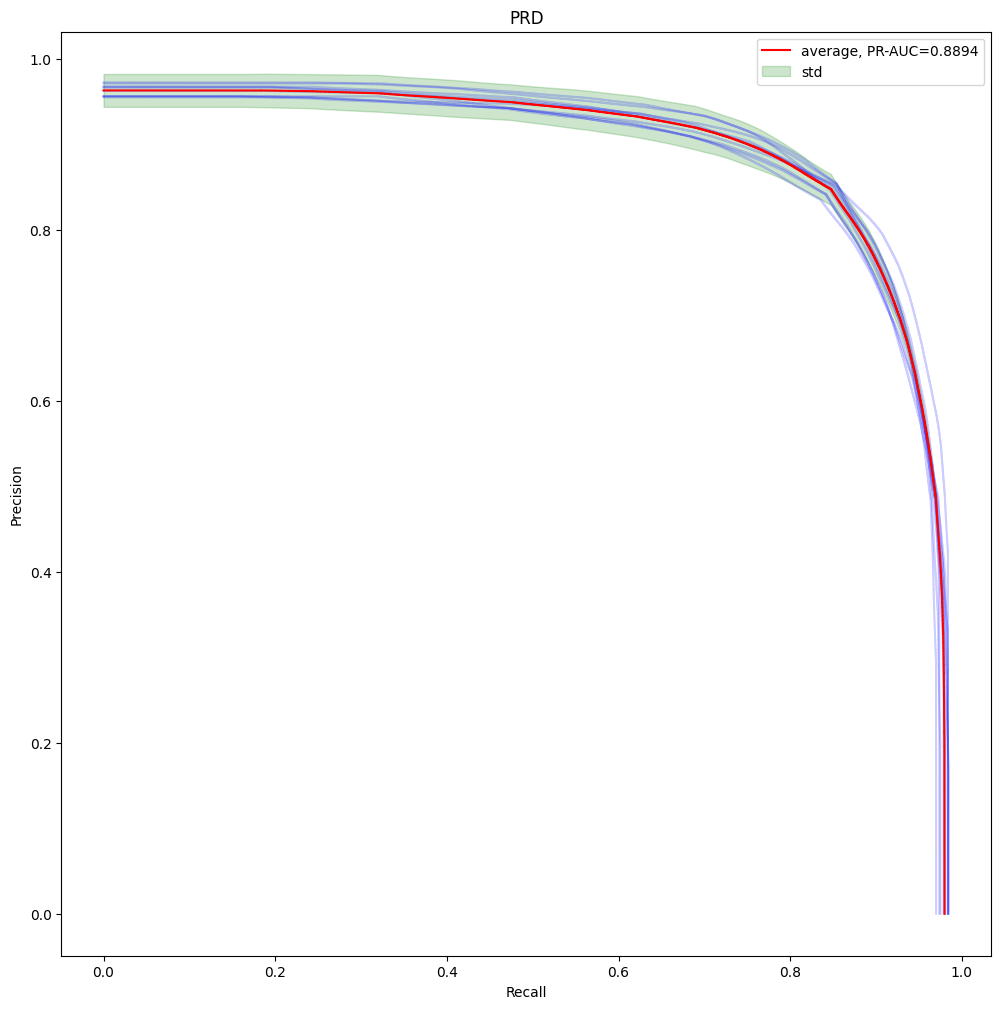

Physics PRD


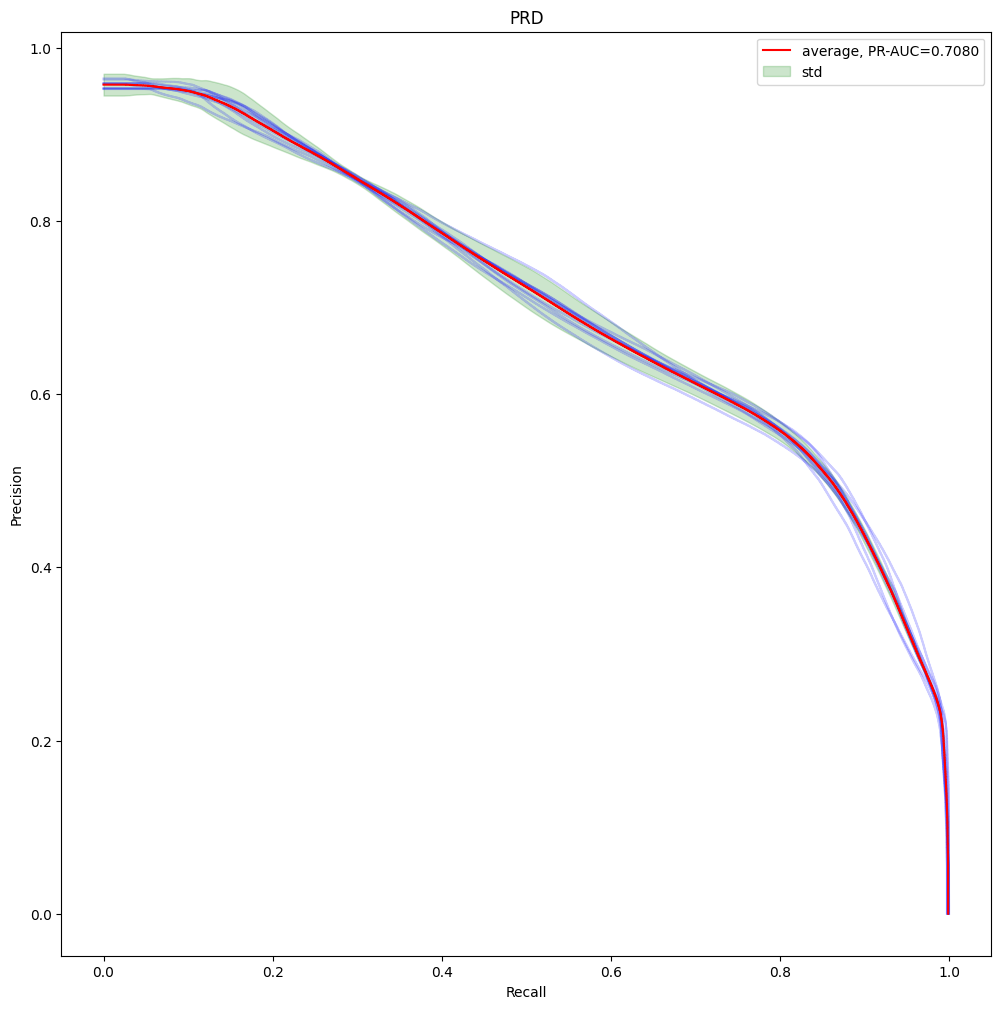

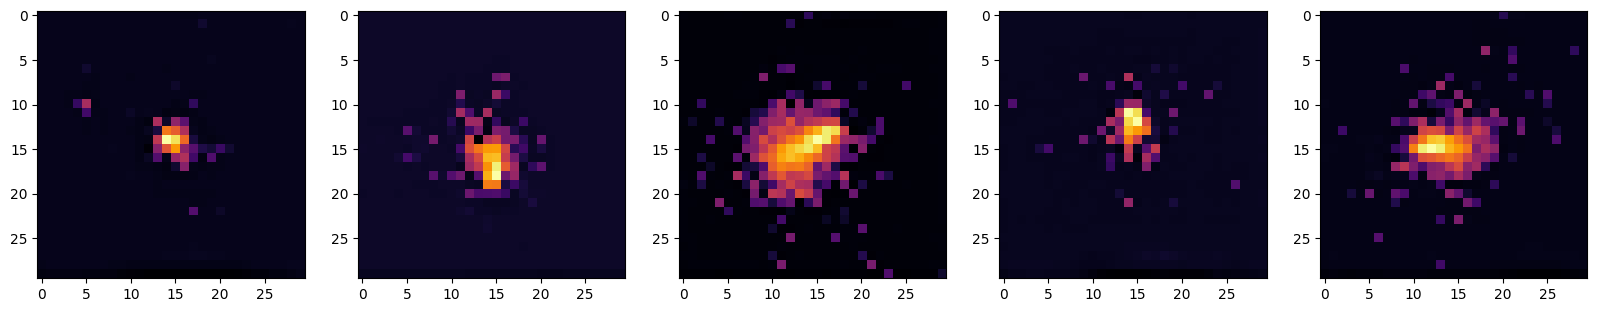

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_39.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_34.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_32.pth', 'checkpoint_epoch_36.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_38.pth', 'checkpoint_epoch_33.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_31.pth', 'checkpoint_epoch_40.pth', 'checkpoint_epoch_35.pth', 

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 41: Avg Loss (Energy Distance): 0.79343


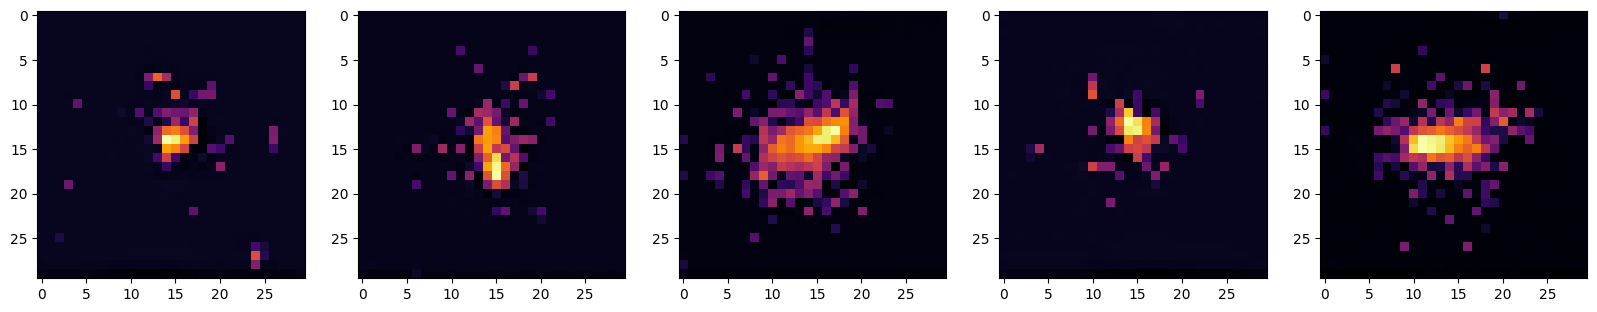

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_41.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_39.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_34.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_32.pth', 'checkpoint_epoch_36.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_38.pth', 'checkpoint_epoch_33.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_31.pth', 'checkpoint_epoch_40.pth', 

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 42: Avg Loss (Energy Distance): 0.79082


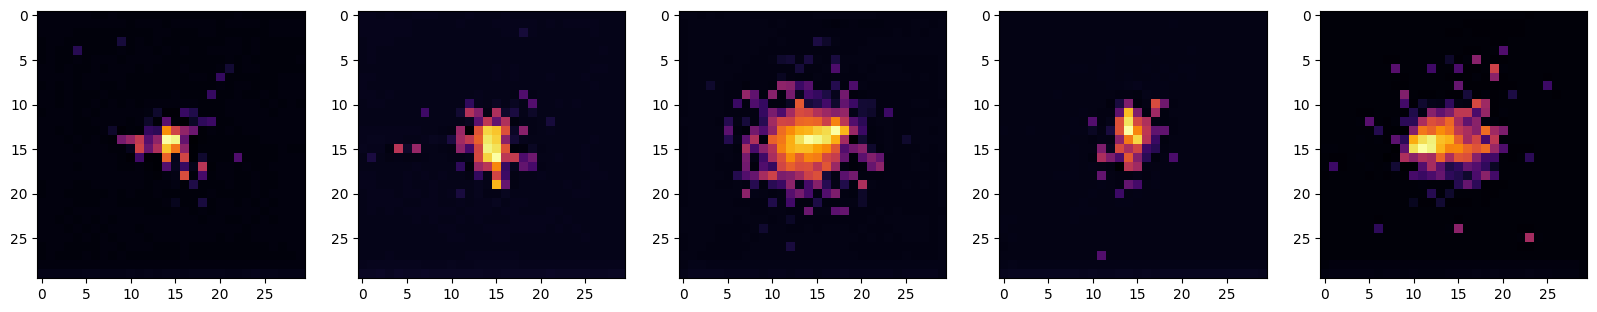

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_41.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_39.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_34.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_42.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_32.pth', 'checkpoint_epoch_36.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_38.pth', 'checkpoint_epoch_33.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_31.pth', 

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 43: Avg Loss (Energy Distance): 0.79625


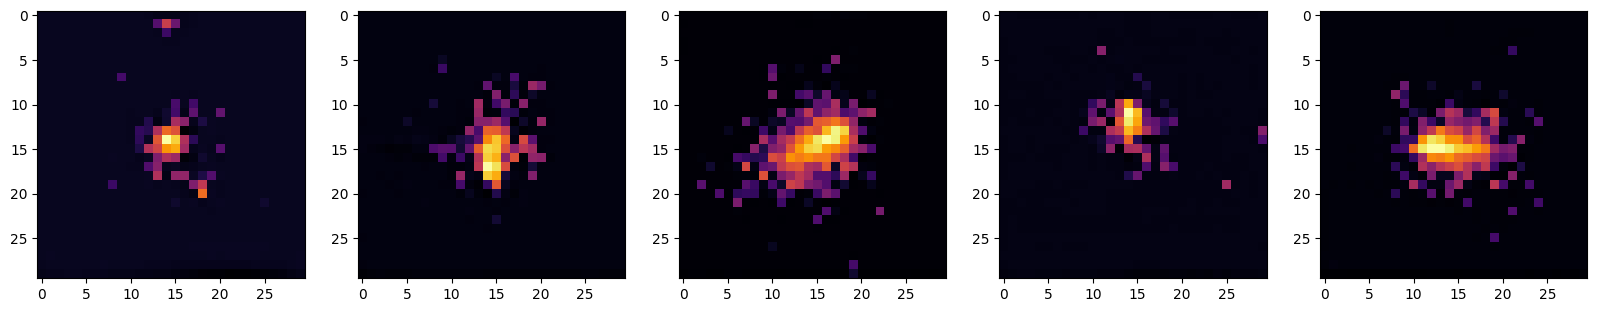

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_41.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_39.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_34.pth', 'checkpoint_epoch_43.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_42.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_32.pth', 'checkpoint_epoch_36.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_38.pth', 'checkpoint_epoch_33.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_20.pth', 

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 44: Avg Loss (Energy Distance): 0.79112


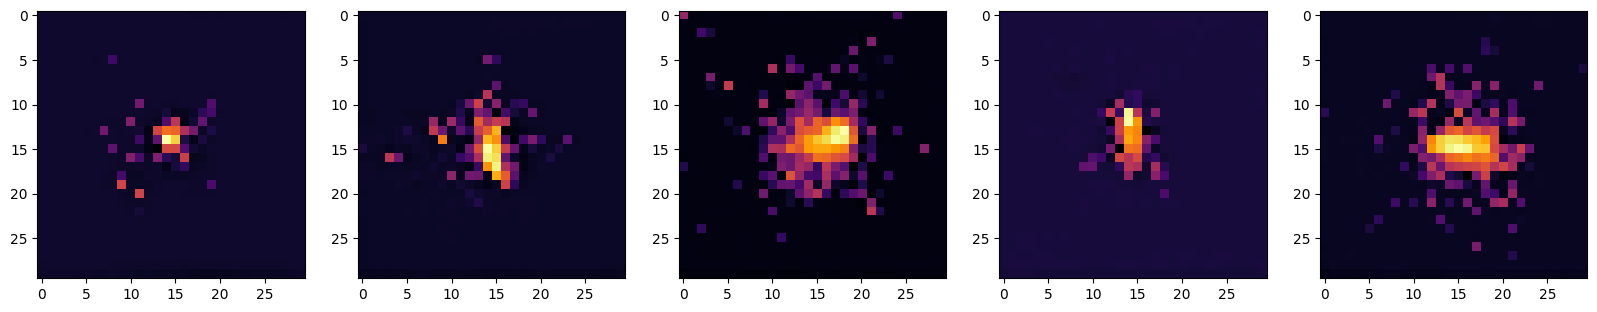

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_44.pth', 'checkpoint_epoch_41.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_39.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_34.pth', 'checkpoint_epoch_43.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_42.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_32.pth', 'checkpoint_epoch_36.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_38.pth', 'checkpoint_epoch_33.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth', 'checkpoint_epoch_1.pth', 

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 45: Avg Loss (Energy Distance): 0.79246


  0%|          | 0/10 [00:00<?, ?it/s]

/kaggle/input/gan-lib/pipeline/physical_metrics/calogan_metrics.py:83: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sum_2 - sum_1 * sum_1)


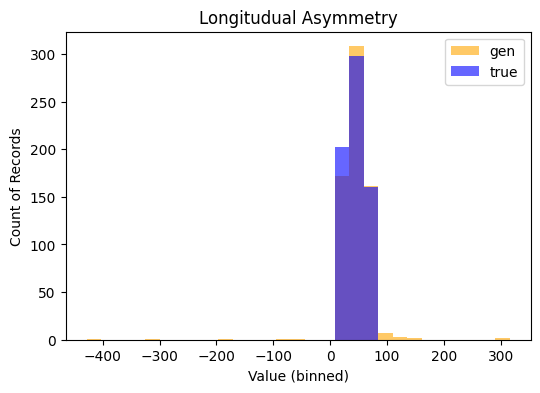

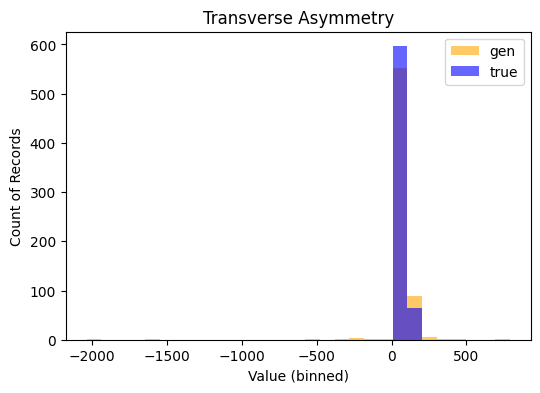

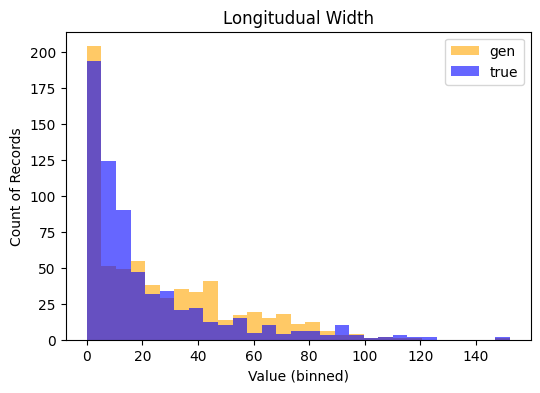

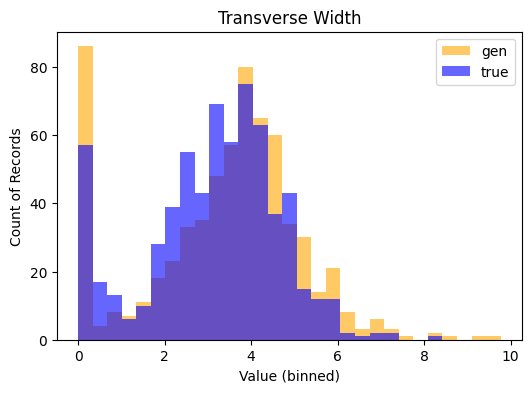

Energy PRD


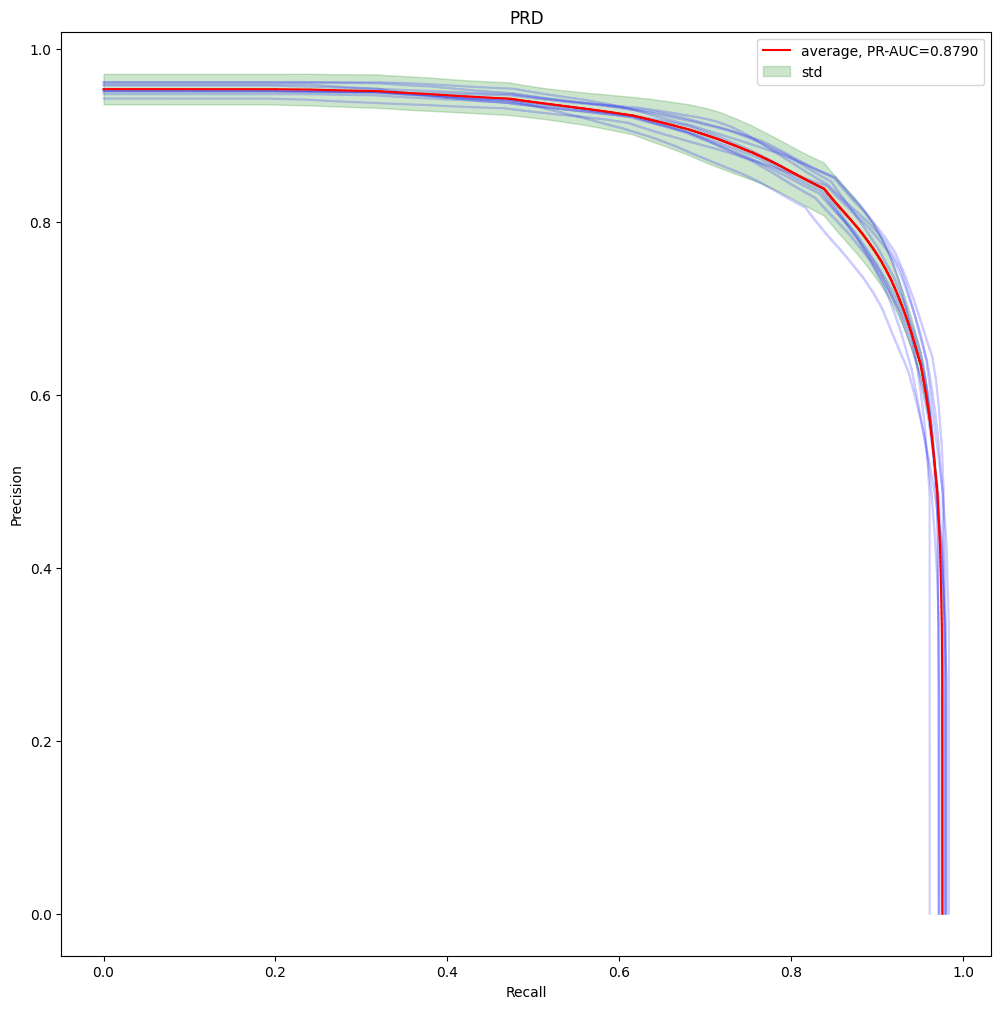

Physics PRD


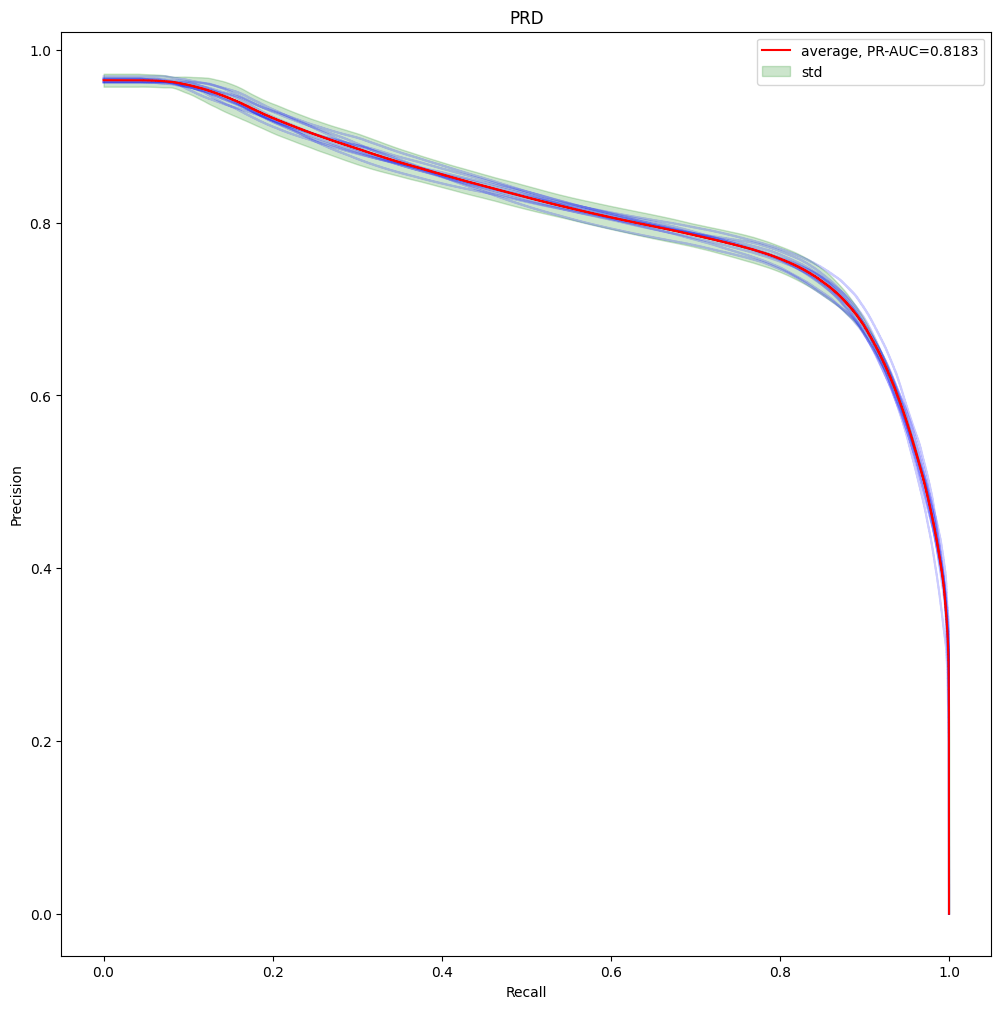

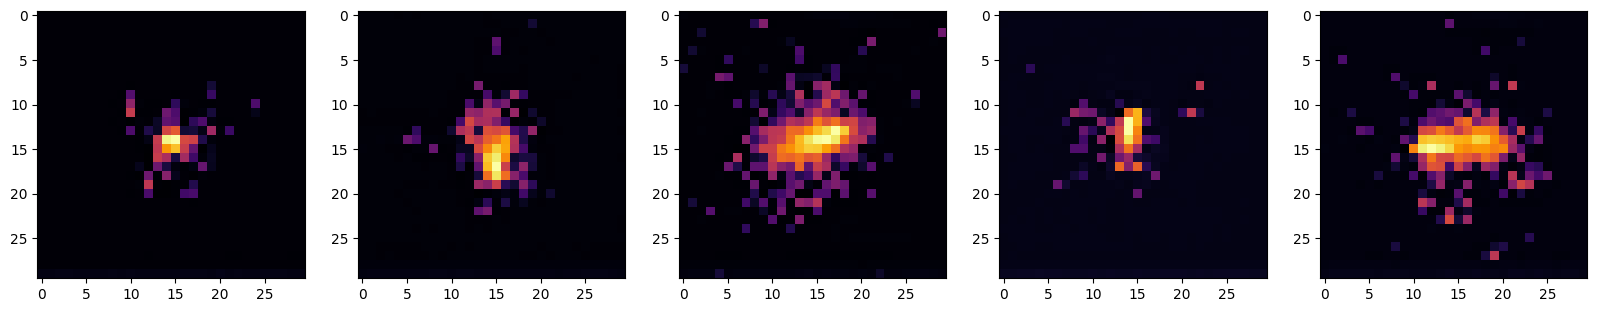

['checkpoint_epoch_8.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_44.pth', 'checkpoint_epoch_41.pth', 'checkpoint_epoch_22.pth', 'checkpoint_epoch_24.pth', 'checkpoint_epoch_39.pth', 'checkpoint_epoch_21.pth', 'checkpoint_epoch_18.pth', 'checkpoint_epoch_6.pth', 'checkpoint_epoch_2.pth', 'checkpoint_epoch_34.pth', 'checkpoint_epoch_43.pth', 'checkpoint_epoch_23.pth', '__notebook__.ipynb', 'checkpoint_epoch_25.pth', 'checkpoint_epoch_17.pth', 'checkpoint_epoch_14.pth', 'checkpoint_epoch_42.pth', 'checkpoint_epoch_4.pth', 'checkpoint_epoch_45.pth', 'checkpoint_epoch_7.pth', 'checkpoint_epoch_9.pth', 'data_demo', 'checkpoint_epoch_26.pth', 'checkpoint_epoch_32.pth', 'checkpoint_epoch_36.pth', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_11.pth', 'checkpoint_epoch_13.pth', 'checkpoint_epoch_12.pth', 'checkpoint_epoch_19.pth', 'checkpoint_epoch_27.pth', 'checkpoint_epoch_38.pth', 'checkpoint_epoch_33.pth', 'checkpoint_epoch_16.pth', 'checkpoint_epoch_29.pth', 'checkpoint_epoch_3.pth',

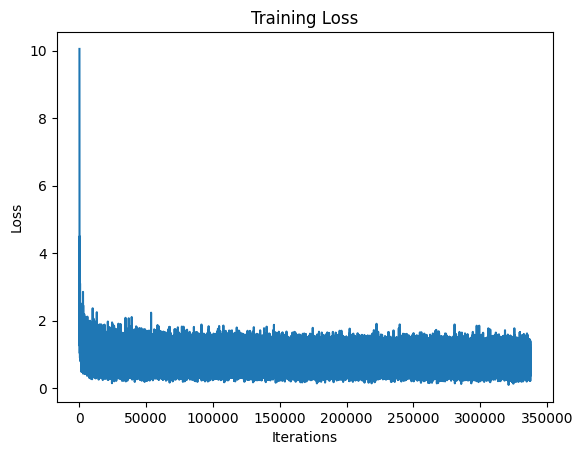

In [26]:
n_epochs = 45
n_steps = 1000

net = MixedConditionedUnet().to(device)
metric_calculator = DiffusionPhysicsMetrics()
loss_fn = energy_distance_loss  # Используем Energy Distance как функцию потерь
opt = torch.optim.RMSprop(net.parameters(), lr=1e-4)

losses = []
energy_distances = []
test_loader = DataLoader(test_data, batch_size=5, shuffle=False)
x_test, y_test = next(iter(test_loader))
y_test = y.to(device)

for epoch in range(n_epochs):
    epoch_energy_distance = []
    for x, y in tqdm(train_loader):
        x = x.to(device)  # Оригинальное изображение
        y = y.to(device)  # Метки
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)  # Добавляем шум
        
        pred = net(noisy_x, 0, y) # Предсказываем чистое изображение (timestep = 0)
        
        loss = loss_fn(x, pred)  # Считаем Energy Distance
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        epoch_energy_distance.append(loss.item())
    
    avg_ed = sum(epoch_energy_distance) / len(epoch_energy_distance)
    energy_distances.append(avg_ed)
    print(f"Epoch {epoch + 1}: Avg Loss (Energy Distance): {avg_ed:.5f}")
    # Пример сохранения контрольной точки
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': opt.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, 'checkpoint_epoch_' + str(epoch + 1) + '.pth')
    if (epoch + 1) in {30, 40, 45}:
        # Валидация и подсчет метрик
        predictions = []
    
        for x_batch, y_batch in tqdm(valid_loader):
            x_batch = torch.rand(8, 1, 30, 30).to(device)
            y_batch = y_batch.to(device)
            
            for i in range(n_steps):
                noise_amount = 0.5 * (1 - torch.cos(torch.tensor(torch.pi * i / n_steps)))
                with torch.no_grad():
                    pred = net(x_batch, 0, y_batch)
        
                mix_factor = 1 / (n_steps - i)
                x_batch = x_batch * (1 - mix_factor) + pred * mix_factor
            
            predictions.append(x_batch.cpu())  # Сохраняем результат на CPU
        
        # Объединяем все предсказания в один тензор
        predictions_valid = torch.cat(predictions, dim=0)
        # Считаем метрики
        metric_calculator.visualize_metrics(predictions_valid, real_images_valid, conditions=y_valid)

    
    
    # Визуализация предсказаний
    test_loader = DataLoader(test_data, batch_size=5, shuffle=False)
    x, y = next(iter(test_loader))
    x = torch.rand(5, 1, 30, 30).to(device)
    y = y.to(device)
    for i in range(n_steps):
        # Косинусное изменение шума
        noise_amount = 0.5 * (1 - torch.cos(torch.tensor(torch.pi * i / n_steps)))
        with torch.no_grad():
            pred = net(x, 0, y)
        
        mix_factor = 1 / (n_steps - i)
        x = x * (1 - mix_factor) + pred * mix_factor

    fig, axs = plt.subplots(1, len(x), figsize=(20, 5))
    for ax, img in zip(axs, x.cpu()):
        energy_imshow(energy=img.cpu(), ax=ax)
    plt.show()
    
    print(os.listdir('.'))

plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()